# Analyzing Service Accessibility and Response Patterns in NYC 311

**Author:** Sagorika Ghosh  
**Course:** DATA 512: Human-Centered Data Science  
**Date:** 9 December 2025

## Introduction

I spent the summer of 2025 interning in New York City, and during those months, I noticed how often people mentioned calling or filing complaints through 311 - whether it was for noise, trash pickup, or heat issues. I used it a few times myself and was struck by how different the experiences felt depending on where I was and how I reported the issue.

This project builds on that experience. I want to explore who reports issues, how they report them (via phone, app, or web), and how quickly those issues are resolved. From a human-centered perspective, this is about everyday access to public services as 311 is like the invisible interface between residents and their city. From a scientific standpoint, it offers a structured way to study how digital reporting channels and geography intersect with urban service response.

Understanding patterns in NYC 311 data could help reveal operational efficiency and equity in visibility and responsiveness. If certain neighborhoods rely on channels that lead to slower closures or lower follow-up, it's important to surface that issue responsibly. My goal is not to assign blame but to highlight data-driven insights that can inform fairer and more transparent city services.

Ultimately, I hope to learn how complaint patterns and response times vary across boroughs and submission channels, and how to present findings in ways that respect privacy and avoid stigmatizing communities.

## Background and Related Work

Several studies have explored various aspects of NYC 311 data, providing important context for this analysis:

### Equity and Reporting Bias

[Kontokosta et al. (2017)](https://doi.org/10.48550/arXiv.1710.02452) showed that complaint data reflects who chooses or is able to report, not just where problems occur. They estimated "propensity to complain" for heat and hot water issues by predicting likely violations and comparing them to observed 311 reports. This research warns against treating raw counts as true incidence and emphasizes the need to analyze channels and geography with care.

### Urban Ecology and Complaint Patterns

[Wang et al. (2017)](https://doi.org/10.1371/journal.pone.0186314) compared NYC, Boston, and Chicago and found that mixes of complaint types track neighborhood context and socioeconomic patterns. This supports my choice to compare like with like within complaint categories, rather than mixing categories across places or channels.

### Bias in Smart City Governance

[Kontokosta & Hong (2021)](https://doi.org/10.1016/j.scs.2020.102503) documented that complaint behavior varies with demographics and income, which can bias any downstream "smart city" use of 311 data. This backs my plan to present borough-level aggregates, run tests within complaint types, and avoid claims about true problem incidence.

### Under-reporting Research

Recent work ([Annals of Applied Statistics, 2025](https://projecteuclid.org/journals/annals-of-applied-statistics/volume-19/issue-2/Estimating-reporting-bias-in-311-complaint-data/10.1214/24-AOAS2003.short)) provides a formal approach to under-reporting for NYC heat and hot water issues. The key takeaway is that "no complaint" often means "not reported," not "no problem." 

Building on this, an [Tool to Estimate ‘311’ Underreporting: NYU press release (2025)](https://www.nyu.edu/about/news-publications/news/2025/may/nyu-researchers-devise-tool-to-estimate--311--underreporting-of-.html) summarizes an automated modeling tool the City can use to assess under-reporting of heat and hot water complaints. While I am not using this tool directly, it reinforces the caution that my study is about reporting and response patterns, not the full incidence of issues.

### Language Access and Technology

[NYC's 311 Language Access Implementation Plan (2024)](https://www.nyc.gov/assets/oti/downloads/pdf/about/oti-311-language-access-plan-2024.pdf) describes interpretation and translation support for 311, including phone interpretation. This shows that channel usability and language access can differ across phone, web, and app.

[NYC 311 testimony to City Council (2024)](https://www.nyc.gov/content/oti/pages/testimony/nyc311-testimony-before-nyc-council-committee-on-technology) notes how the mobile app connects to live agents with Language Line and outlines ongoing improvements to digital access. These documents provide context for why channel choice could vary across communities and how that might relate to response times.

### How Prior Work Informs This Study

These findings inform my study design and research questions by highlighting the importance of:
- Analyzing 2024 data only and aggregating at the borough level to reduce the risk of neighborhood-level stigma and to reflect the known socio-spatial reporting differences
- Comparing response times across channels within the same complaint categories so that category mix does not mask channel effects
- Not interpreting counts as true incidence of problems. Under-reporting and channel accessibility mean I'm studying patterns in reporting and response, not the full universe of issues
- Acknowledging that channel accessibility, language access, and technology improvements can affect who uses which reporting method and their experience

## Dataset Description

### Data Source

This analysis uses the [NYC 311 Service Requests dataset](https://data.cityofnewyork.us/Social-Services/311-Service-Requests-from-2010-to-Present/erm2-nwe9/about_data) from the NYC Open Data Portal. The dataset contains all service requests submitted to NYC's 311 system from 2010 to present, with over 40 million records total.

**Dataset Details:**
- **Source**: NYC Open Data Portal
- **Dataset ID**: erm2-nwe9
- **License**: [NYC Open Data Terms of Use](https://www.nyc.gov/main/terms-of-use) and [NYC Open Data Law](https://opendata.cityofnewyork.us/open-data-law/)
- **Data Collection Date**: November 17, 2024
- **Analysis Period**: Calendar year 2024 (January 1 - December 31, 2024)
- **Records Analyzed**: 1,869,316 service requests (after cleaning)

### Key Fields

The analysis focuses on the following fields:

- `unique_key`: Unique identifier for each request
- `created_date`: When the complaint was filed
- `closed_date`: When the complaint was resolved
- `complaint_type`: Category of complaint (e.g., "Noise - Residential", "HEAT/HOT WATER")
- `borough`: NYC borough (Bronx, Brooklyn, Manhattan, Queens, Staten Island)
- `incident_zip`: ZIP code where the issue occurred
- `open_data_channel_type`: How the complaint was submitted (Phone, Web, App)
- `agency`: City agency responsible for handling the request
- `latitude`, `longitude`: Geographic coordinates

### Data Access

The data was accessed via the [Socrata Open Data API (SODA)](https://dev.socrata.com/) using Python. Due to the dataset's size, I used API filters to extract only 2024 records:

```python
# API query parameters
params = {
    "$where": "created_date between '2024-01-01T00:00:00' and '2024-12-31T23:59:59'",
    "$limit": 25000,
    "$offset": 0,
    "$order": "created_date"
}

Below cell imports the necessary libraries

In [ ]:
#!python3 -m pip install seaborn matplotlib plotly scikit-learn pyarrow

## Setting up the analysis environment

The next cell imports the standard analysis libraries and sets display options so the tables are easy to scan.

In [2]:
import pandas as pd
import numpy as np
from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt

pd.set_option("display.max_columns", 50)
pd.set_option("display.float_format", lambda x: f"{x:,.2f}")
plt.style.use("seaborn-v0_8-colorblind")

## Data Processing Pipeline

**Note on Data Cleaning**: The raw data acquisition and cleaning steps are documented in a separate notebook: `00_data_cleaning.ipynb`. This supplementary notebook handles the initial data processing before this analysis begins.

### Data Cleaning Notebook Details

- **Notebook**: `00_data_cleaning.ipynb` (located in `notebooks/` directory)
- **Purpose**: Fetches raw 2024 data from NYC Open Data API and performs all cleaning/preprocessing steps
- **When Used**: This notebook should be run FIRST, before running this analysis notebook
- **Input**: 
  - NYC Open Data API (live data fetch)
  - API credentials from `.env` file (optional, uses app token if available)
- **Output**: 
  - `data/raw/nyc311_2024_raw.parquet` (3,458,320 records, ~364 MB)
  - `data/processed/nyc311_2024_cleaned.parquet` (1,869,316 records, ~197 MB)
- **Sample Data**: For reproducibility without API access, a sample dataset is provided in `data/sample/nyc311_2024_sample.parquet` (1,000 records)

### Cleaning Steps Performed

The `00_data_cleaning.ipynb` notebook performs the following transformations (reducing 3.4M records to 1.9M):

1. Date conversion and response time calculation
2. Removal of invalid records (missing dates, negative response times)
3. Channel type standardization (Phone/Web/App)
4. Duplicate removal
5. Outlier treatment (99th percentile winsorization)
6. Top complaint type selection

**For this analysis, we load the pre-cleaned data** from `data/processed/nyc311_2024_cleaned.parquet`.

## Loading the cleaned 2024 dataset

The next cell loads the processed parquet file from the helper notebook so I can analyze the top complaint types across channels without re-downloading raw data.

In [3]:
PROJECT_ROOT = Path('..').resolve()
processed_path = PROJECT_ROOT / 'data' / 'processed' / 'nyc311_2024_cleaned.parquet'
sample_path = PROJECT_ROOT / 'data' / 'sample' / 'nyc311_2024_sample.parquet'

if processed_path.exists():
    print(f"Loading cleaned data from {processed_path}")
    df = pd.read_parquet(processed_path)
elif sample_path.exists():
    print(f"WARNING: Full dataset not found. Loading SAMPLE dataset from {sample_path}")
    print("Results will be illustrative only.")
    df = pd.read_parquet(sample_path)
else:
    raise FileNotFoundError(f"Neither full dataset ({processed_path}) nor sample dataset ({sample_path}) found.")

print(f"Loaded {len(df):,} rows and {len(df.columns)} columns")
df.head()

Loading cleaned data from /Users/sagorika/Downloads/A7/data/processed/nyc311_2024_cleaned.parquet
Loaded 1,869,316 rows and 42 columns


,unique_key,created_date,closed_date,agency,agency_name,complaint_type,descriptor,location_type,incident_zip,incident_address,street_name,cross_street_1,cross_street_2,intersection_street_1,intersection_street_2,address_type,city,landmark,status,resolution_description,resolution_action_updated_date,community_board,bbl,borough,x_coordinate_state_plane,y_coordinate_state_plane,open_data_channel_type,park_facility_name,park_borough,latitude,longitude,location,facility_type,bridge_highway_name,bridge_highway_segment,taxi_pick_up_location,vehicle_type,bridge_highway_direction,road_ramp,taxi_company_borough,due_date,response_time_days
0,59889016,2024-01-01 00:00:20,2024-01-01 00:59:31,NYPD,New York City Police Department,Noise - Residential,Loud Music/Party,Residential Building/House,10468,233 LANDING ROAD,LANDING ROAD,CEDAR AVENUE,MAJOR DEEGAN EXPRESSWAY,CEDAR AVENUE,MAJOR DEEGAN EXPRESSWAY,ADDRESS,BRONX,LANDING ROAD,Closed,The Police Department responded to the complai...,2024-01-01T00:59:34.000,07 BRONX,2032367501,BRONX,1008841,253488,Phone,Unspecified,BRONX,40.86240645467484,-73.91109714827905,"{'human_address': '{""address"": """", ""city"": """",...",None,None,None,None,None,None,None,None,None,0.04
1,59888940,2024-01-01 00:00:43,2024-01-01 00:56:45,NYPD,New York City Police Department,Noise - Residential,Banging/Pounding,Residential Building/House,11207,640 STANLEY AVENUE,STANLEY AVENUE,VERMONT STREET,VAN SICLEN AVENUE,VERMONT STREET,VAN SICLEN AVENUE,ADDRESS,BROOKLYN,STANLEY AVENUE,Closed,The Police Department responded to the complai...,2024-01-01T00:56:50.000,05 BROOKLYN,3043710001,BROOKLYN,1016195,179364,App,Unspecified,BROOKLYN,40.65893182677183,-73.88486278314905,"{'human_address': '{""address"": """", ""city"": """",...",None,None,None,None,None,None,None,None,None,0.04
2,59892651,2024-01-01 00:00:48,2024-01-01 00:48:34,NYPD,New York City Police Department,Noise - Street/Sidewalk,Loud Music/Party,Street/Sidewalk,11377,41-52 72 STREET,72 STREET,41 AVENUE,WOODSIDE AVENUE,41 AVENUE,WOODSIDE AVENUE,ADDRESS,WOODSIDE,72 STREET,Closed,The Police Department responded to the complai...,2024-01-01T00:48:39.000,02 QUEENS,4013110066,QUEENS,1013848,210267,Web,Unspecified,QUEENS,40.74376141146886,-73.8931860929054,"{'human_address': '{""address"": """", ""city"": """",...",None,None,None,None,None,None,None,None,None,0.03
3,59889054,2024-01-01 00:00:51,2024-01-01 00:29:32,NYPD,New York City Police Department,Noise - Street/Sidewalk,Loud Music/Party,Street/Sidewalk,11416,85-04 95 AVENUE,95 AVENUE,85 STREET,86 STREET,85 STREET,86 STREET,ADDRESS,OZONE PARK,95 AVENUE,Closed,The Police Department responded to the complai...,2024-01-01T00:29:34.000,09 QUEENS,4090210002,QUEENS,1024256,188778,App,Unspecified,QUEENS,40.68473836098068,-73.85575323670186,"{'human_address': '{""address"": """", ""city"": """",...",None,None,None,None,None,None,None,None,None,0.02
4,59892073,2024-01-01 00:01:01,2024-01-01 01:32:22,NYPD,New York City Police Department,Noise - Street/Sidewalk,Loud Music/Party,Street/Sidewalk,11434,144-25 153 LANE,153 LANE,SOUTH CONDUIT AVENUE,146 AVENUE,SOUTH CONDUIT AVENUE,146 AVENUE,ADDRESS,JAMAICA,153 LANE,Closed,The Police Department responded to the complai...,2024-01-01T01:32:26.000,13 QUEENS,4150010087,QUEENS,1043908,182029,App,Unspecified,QUEENS,40.66610329232783,-73.78495540739017,"{'human_address': '{""address"": """", ""city"": """",...",None,None,None,None,None,None,None,None,None,0.06


## Dataset overview

The next cell summarizes the cleaned dataset to confirm the complaint mix, channel distribution, and borough coverage before diving into the research questions.

In [4]:
summary = {
    "rows": len(df),
    "columns": len(df.columns),
    "date_range": (df["created_date"].min(), df["created_date"].max()),
}

print("Dataset summary:")
for key, value in summary.items():
    print(f"  {key}: {value}")

print("\nComplaint types:")
print(df["complaint_type"].value_counts())

print("\nChannel distribution:")
print(df["open_data_channel_type"].value_counts())

print("\nBorough distribution:")
print(df["borough"].value_counts())

Dataset summary:
  rows: 1869316
  columns: 42
  date_range: (Timestamp('2024-01-01 00:00:20'), Timestamp('2024-12-31 23:59:33'))

Complaint types:
complaint_type
Illegal Parking            505732
Noise - Residential        379252
HEAT/HOT WATER             261748
Blocked Driveway           170190
Noise - Street/Sidewalk    162997
UNSANITARY CONDITION       120699
Abandoned Vehicle           70326
Noise - Commercial          68334
PLUMBING                    65767
PAINT/PLASTER               64271
Name: count, dtype: int64

Channel distribution:
open_data_channel_type
Web      758634
App      561853
Phone    548829
Name: count, dtype: int64

Borough distribution:
borough
BROOKLYN         580861
BRONX            486025
QUEENS           428697
MANHATTAN        329076
STATEN ISLAND     44594
Unspecified          63
Name: count, dtype: int64


## Research Questions

During my summer in NYC, I noticed how different the 311 experience felt depending on where I was and how I reported issues. This analysis explores 4 questions that connect those observations to patterns in the data:

1. **How do average 311 response times differ across boroughs in 2024?**
   
   I majorly try to analyse the following 2 questions for this part: 
   - (a) How do median and mean response times compare across boroughs, and what patterns emerge in the distributions? 
   - (b) How do these response time patterns relate to the volume of complaints each borough receives? 
   
   I examine summary statistics by borough, visualize the patterns with box plots and bar charts, and create a geographic map showing where reports originate and their response times. This provides the baseline for understanding citywide patterns.

2. **Which ZIP codes have statistically significant response time problems, and do certain complaint types cluster in slow-responding neighborhoods?**
   
   This question has 3 subparts: 
   - (a) Do response times vary significantly across ZIP codes within each borough, as measured by statistical tests? 
   - (b) Which specific ZIP codes have the slowest response times, and do they form geographic clusters? 
   - (c) Do certain complaint types cluster in slow-responding neighborhoods, and are some ZIP codes slow across multiple complaint types? 
   
   I use Kruskal-Wallis tests to identify ZIP codes with significantly slower responses within each borough, create geographic maps to visualize clusters, and analyze complaint-type interactions to see which neighborhoods face delays for specific types of issues. This helps identify not just where problems occur, but which types of complaints are most affected in those areas.

3. **Do digital channels lead to faster responses than phone reports, and which complaint types rely most on phone reporting?**
   
   We can explore this question by answering the following sub questions: 
   - (a) For the same complaint types within the same borough, do digital channels (app or web) receive faster responses than phone reports? 
   - (b) Which complaint types rely most on phone reporting versus digital channels? 
   - (c) Do phone-heavy complaint types experience systematically slower closure times compared to digitally reported complaints? 
   
   I compare response times across Phone, Web, and App channels while controlling for complaint type and borough to isolate the channel effect. I also analyze which complaint types are reported primarily through phone versus digital channels, and whether phone-heavy complaint types experience systematically slower closure times. This tests whether digital access leads to faster service and identifies whether certain types of issues face access barriers.

4. **Does complaint volume or seasonal workload amplify delays, or do some boroughs and complaint types remain slow even during low-demand periods?**
   
   I examine whether high complaint volumes or seasonal patterns explain response time delays, or if some areas and complaint types remain slow regardless of workload. This helps distinguish between capacity constraints and systemic service differences.

5. **Can we predict whether a complaint will be slower than the norm for its issue, and which structural factors drive that risk?**
   
   I train a simple classifier using complaint-type-specific slow labels (75th percentile per type) to see if we can flag slow responses at submission time. This quantifies which contextual factors: borough, season, channel, agency - matter most and whether geography still dominates even after controlling for the issue itself.


## Methodology

### Data Cleaning

The raw 2024 data underwent several cleaning steps (implemented in [src/nyc311_cleaning.py](cci:7://file:///d:/UW/Q4/HCDS/Final%20Project/A7/src/nyc311_cleaning.py:0:0-0:0)):

1. **Date Conversion**: Converted `created_date` and `closed_date` from strings to datetime format
2. **Response Time Calculation**: Calculated `response_time_days` = `closed_date` - `created_date`
3. **Invalid Record Removal**: Removed records with:
   - Missing `created_date`, `closed_date`, or `borough`
   - Negative or zero response times (data entry errors)
4. **Channel Standardization**: Standardized `open_data_channel_type` to three values:
   - PHONE to Phone
   - ONLINE/UNKNOWN/OTHER to Web
   - MOBILE to App
5. **Duplicate Removal**: Removed duplicate records using `unique_key`
6. **Outlier Treatment**: Winsorized response times at the 99th percentile (273.21 days) to limit outlier influence
7. **Complaint Type Selection**: Selected top 10 complaint types by volume for reliable within-category comparisons

This process reduced the dataset from 3,458,320 raw records to 1,869,316 cleaned records.

### Analysis Methods
- **Descriptive Statistics**: I calculated median, mean, standard deviation, minimum, and maximum response times by borough, channel, and complaint type. I focused on medians because response times are heavily right-skewed.
- **Statistical Testing (RQ2)**: To statistically validate the observed disparities in response times across boroughs, I employed the **Kruskal-Wallis H-test**, a non-parametric alternative to ANOVA suitable for non-normally distributed data. Significant findings indicate that at least one borough's response time distribution differs from the others.
- **Predictive Modeling (RQ5)**: I built a Random Forest classifier to understand what factors are associated with slow service. I defined the target as a binary label based on whether response time exceeded the global median, and included features such as complaint type, borough, channel, and time of submission. I evaluated the model using the ROC-AUC score and used feature importance to identify which predictors most strongly influence delays. This helped distinguish between procedural bottlenecks and potential structural patterns.
- **Visualizations**: To explore patterns visually, I created bar charts showing borough-level averages and medians, box plots illustrating distribution and spread, geographic maps built with Plotly to show spatial patterns of response times, and interactive maps that group complaints into small grid cells for clearer visualization of dense regions.

### Why These Methods Are Appropriate
Median-based analysis provides a more stable representation of response patterns when outliers are present. Non-parametric tests like Kruskal-Wallis are well suited for non-normal service data, and the model choice allows handling interactions between multiple features without heavy assumptions. Comparing channels within the same complaint type avoids misleading cross-type comparisons since different complaints have inherently different resolution times. Borough-level analysis maintains privacy while still revealing useful insights, and ZIP-level results are used cautiously. Winsorizing the top 1 percent of values limits extreme outlier influence while preserving distribution shape, and focusing on top complaint types ensures that comparisons are based on reliable sample sizes.

### Ethical Considerations
It is important to acknowledge that 311 data reflects who reports issues, not the full experience of all residents. I avoid interpreting results as objective measures of community conditions. To protect privacy, I removed free-text fields and presented results only at borough or ZIP aggregation levels. I am careful not to label any neighborhood as problematic and instead focus on systemic service patterns, potential sources of delay, and opportunities for improvement.

## Analysis and Findings

## Research Question 1: How do average 311 response times differ across boroughs in 2024?

This question connects to my summer experience where I noticed response times seemed to vary by neighborhood. We will look at 2 analyses: 
- (a) How do median and mean response times compare across boroughs, and what patterns emerge in the distributions? 
- (b) How do these response time patterns relate to the volume of complaints each borough receives? I start by computing summary statistics for each borough, then visualize the patterns with box plots and bar charts, and create a geographic map showing where reports originate and their response times.

In the next cell, I'll be filtering out unspecified boroughs for analysis and compute the response time statistics by borough.

In [5]:
# filtering out unspecified boroughs for analysis
df_boroughs = df[df["borough"] != "Unspecified"].copy()

# computing response time statistics by borough
rq1_summary = (
    df_boroughs.groupby("borough")["response_time_days"]
    .agg(["count", "mean", "median", "std", "min", "max"])
    .round(3)
    .sort_values("median")
)

print("Response time statistics by borough (in days):")
print(rq1_summary)

rq1_summary_hours = rq1_summary.copy()
for col in ["mean", "median", "std", "min", "max"]:
    rq1_summary_hours[col] = rq1_summary[col] * 24

print("\n\nResponse time statistics by borough (in hours):")
print(rq1_summary_hours)

Response time statistics by borough (in days):
                count  mean  median   std  min    max
borough                                              
STATEN ISLAND   44594  1.99    0.05  8.38 0.00 273.21
MANHATTAN      329076  4.19    0.05 18.97 0.00 273.21
BROOKLYN       580861  2.76    0.07 12.12 0.00 273.21
QUEENS         428697  1.62    0.10  9.27 0.00 273.21
BRONX          486025  3.40    0.23 12.74 0.00 273.21


Response time statistics by borough (in hours):
                count   mean  median    std  min      max
borough                                                  
STATEN ISLAND   44594  47.81    1.10 201.14 0.00 6,556.94
MANHATTAN      329076 100.54    1.27 455.18 0.00 6,556.94
BROOKLYN       580861  66.26    1.63 291.00 0.00 6,556.94
QUEENS         428697  38.86    2.30 222.53 0.00 6,556.94
BRONX          486025  81.48    5.57 305.66 0.00 6,556.94


### Visualizing borough-level response times

The next cell creates four visualizations:
1. **Median response times** (top-left): Shows the typical response time for each borough
2. **Mean response times** (top-right): Shows the average, which can be pulled higher by outliers
3. **Response time distribution** (bottom-left): Box plots show the spread, quartiles, and outliers - revealing how consistent response times are within each borough
4. **Complaint volume** (bottom-right): Shows how many complaints each borough generates

The box plot shows the full distribution (25th percentile, median, 75th percentile, and outliers) rather than just a single summary statistic. This helps us see if some boroughs have more variable response times than others.

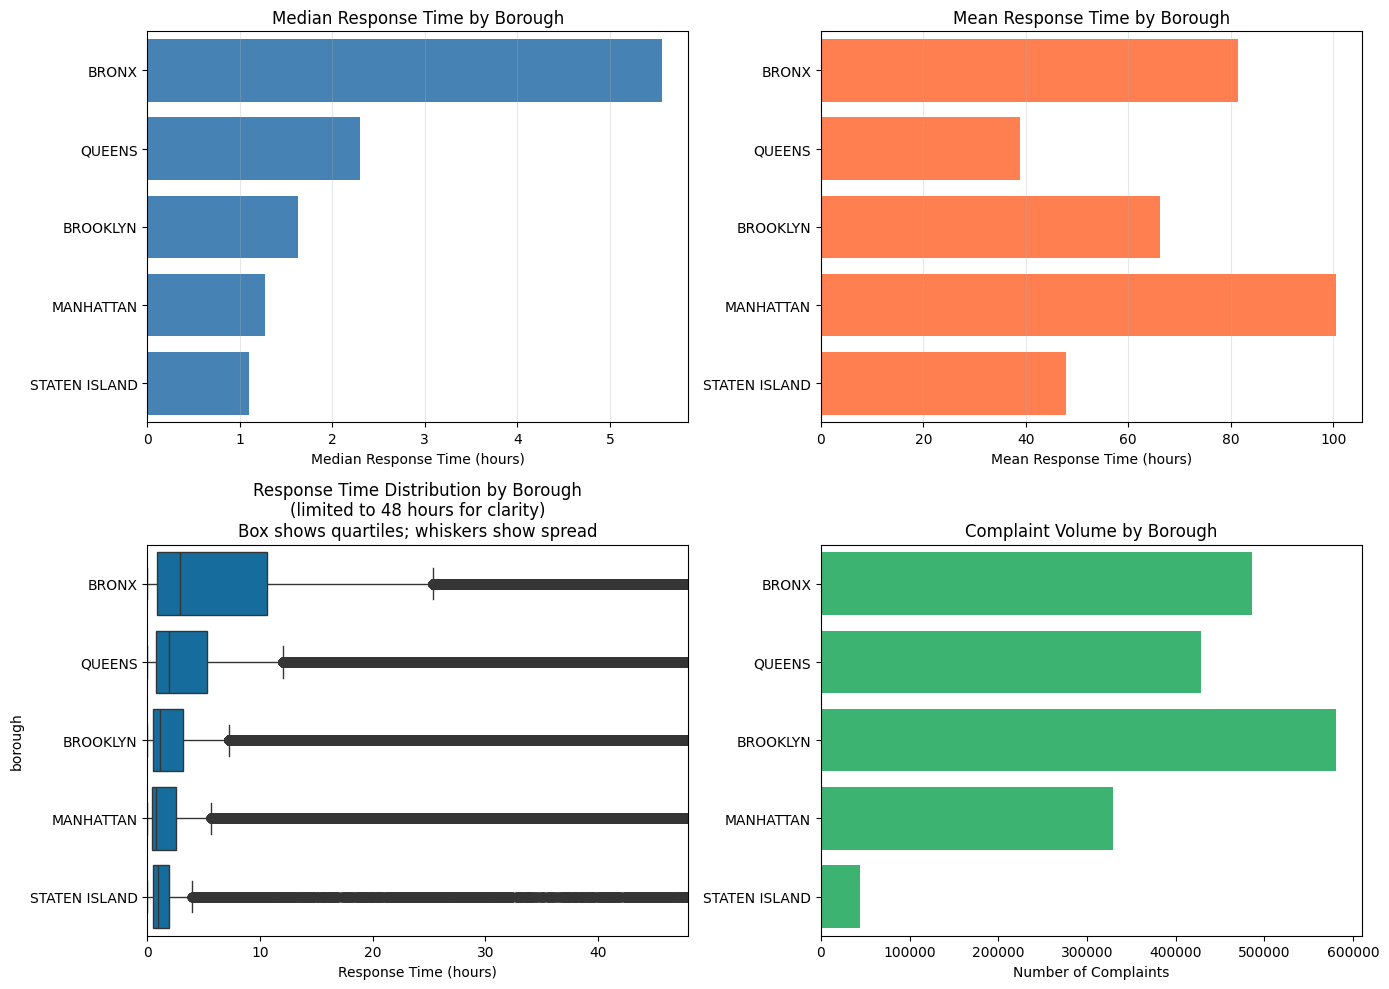

In [6]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# defining consistent borough order (sorted by median, ascending - fastest to slowest)
borough_order = rq1_summary.sort_values("median").index

# subplot 1: median response times by borough
ax1 = axes[0, 0]
ax1.barh(borough_order, rq1_summary.loc[borough_order, "median"] * 24, color="steelblue")
ax1.set_xlabel("Median Response Time (hours)")
ax1.set_title("Median Response Time by Borough")
ax1.grid(axis="x", alpha=0.3)
ax1.set_ylim(-0.5, len(borough_order) - 0.5)

# subplot 2: mean response times by borough
ax2 = axes[0, 1]
ax2.barh(borough_order, rq1_summary.loc[borough_order, "mean"] * 24, color="coral")
ax2.set_xlabel("Mean Response Time (hours)")
ax2.set_title("Mean Response Time by Borough")
ax2.grid(axis="x", alpha=0.3)
ax2.set_ylim(-0.5, len(borough_order) - 0.5)

# subplot 3: box plot of response times by borough
ax3 = axes[1, 0]
df_boroughs["response_time_hours"] = df_boroughs["response_time_days"] * 24
df_box = df_boroughs[df_boroughs["response_time_hours"] <= 48].copy()
sns.boxplot(data=df_box, y="borough", x="response_time_hours", ax=ax3, order=borough_order)
ax3.set_xlabel("Response Time (hours)")
ax3.set_title("Response Time Distribution by Borough\n(limited to 48 hours for clarity)\nBox shows quartiles; whiskers show spread")
ax3.set_xlim(0, 48)
ax3.invert_yaxis()

# subplot 4: complaint volume by borough
ax4 = axes[1, 1]
complaint_counts = df_boroughs["borough"].value_counts().reindex(borough_order)
ax4.barh(borough_order, complaint_counts.values, color="mediumseagreen")
ax4.set_xlabel("Number of Complaints")
ax4.set_title("Complaint Volume by Borough")
ax4.set_ylim(-0.5, len(borough_order) - 0.5)

plt.tight_layout()
plt.savefig(PROJECT_ROOT / "figures" / "rq1_borough_response_times.png", dpi=300, bbox_inches="tight")
plt.show()

### Geographic map of complaint hotspots and response times

The next cell creates an interactive map showing where complaints originate and their average response times. Points are aggregated into 0.005-degree bins (approximately 500m) to make the visualization manageable - this means each point represents all complaints within that area. Hover over points to see detailed information about each location including borough, complaint count, and average response time. This helps visualize spatial patterns I noticed during my summer, where certain neighborhoods seemed to have different response experiences.

Note: The gaps between points are due to aggregation - complaints exist throughout NYC, but we group them into bins for visualization. The finer binning (0.005 degrees) provides better spatial coverage than the previous 0.01-degree bins.

In [7]:
# aggregating by location
df_map = df_boroughs[
    (df_boroughs["latitude"].notna()) & 
    (df_boroughs["longitude"].notna()) &
    (df_boroughs["latitude"] != 0) &
    (df_boroughs["longitude"] != 0)
].copy()

# converting latitude and longitude to numeric (they come as strings from the API)
df_map["latitude"] = pd.to_numeric(df_map["latitude"], errors="coerce")
df_map["longitude"] = pd.to_numeric(df_map["longitude"], errors="coerce")

# filtering again after conversion to remove any invalid numeric values
df_map = df_map[
    (df_map["latitude"].notna()) & 
    (df_map["longitude"].notna()) &
    (df_map["latitude"] != 0) &
    (df_map["longitude"] != 0)
].copy()

print(f"Records with valid coordinates: {len(df_map):,} ({len(df_map)/len(df_boroughs)*100:.1f}%)")

# creating aggregated data for mapping (binning coordinates to reduce data points) using finer binning (0.005 degrees ≈ 500m) for better spatial coverage
bin_precision = 200 
df_map["lat_bin"] = (df_map["latitude"] * bin_precision).round() / bin_precision
df_map["lon_bin"] = (df_map["longitude"] * bin_precision).round() / bin_precision

map_agg = (
    df_map.groupby(["lat_bin", "lon_bin", "borough"])
    .agg({
        "response_time_days": "mean",
        "unique_key": "count"
    })
    .reset_index()
    .rename(columns={"unique_key": "complaint_count", "response_time_days": "avg_response_days"})
)

print(f"Aggregated points for mapping: {len(map_agg):,}")
print(f"Bin size: 0.005 degrees (≈500m) - this provides better spatial coverage")
print(f"Each point represents complaints within a ~500m x 500m area")

map_agg["avg_response_hours"] = map_agg["avg_response_days"] * 24
response_stats = map_agg["avg_response_hours"].describe()
print(f"\nResponse time distribution (hours) for color scale:")
print(f"  Min: {response_stats['min']:.2f}")
print(f"  25th percentile: {response_stats['25%']:.2f}")
print(f"  Median: {response_stats['50%']:.2f}")
print(f"  75th percentile: {response_stats['75%']:.2f}")
print(f"  95th percentile: {map_agg['avg_response_hours'].quantile(0.95):.2f}")
print(f"  99th percentile: {map_agg['avg_response_hours'].quantile(0.99):.2f}")
print(f"  Max: {response_stats['max']:.2f}")

# setting color scale range to 95th percentile to avoid extreme outliers
color_percentile = 0.95
color_max = map_agg["avg_response_hours"].quantile(color_percentile)
print(f"\nUsing color scale range: 0 to {color_max:.1f} hours ({color_percentile*100:.0f}th percentile)")
print(f"\nSample of aggregated data:")
print(map_agg.head(10))

Records with valid coordinates: 1,862,884 (99.7%)
Aggregated points for mapping: 3,169
Bin size: 0.005 degrees (≈500m) - this provides better spatial coverage
Each point represents complaints within a ~500m x 500m area

Response time distribution (hours) for color scale:
  Min: 0.08
  25th percentile: 6.94
  Median: 30.43
  75th percentile: 70.46
  95th percentile: 148.93
  99th percentile: 233.33
  Max: 1596.96

Using color scale range: 0 to 148.9 hours (95th percentile)

Sample of aggregated data:
   lat_bin  lon_bin        borough  avg_response_days  complaint_count  \
0    40.50   -74.25  STATEN ISLAND               0.01                1   
1    40.50   -74.25  STATEN ISLAND               0.06                3   
2    40.50   -74.25  STATEN ISLAND               0.05               41   
3    40.50   -74.24  STATEN ISLAND               0.05              140   
4    40.50   -74.23  STATEN ISLAND               0.06                4   
5    40.51   -74.25  STATEN ISLAND               0.

### Creating the interactive map visualization

The next cell creates an interactive Plotly scatter plot showing complaint hotspots across NYC. Each point is colored by average response time (yellow = fast, red = slow) and sized by complaint volume. The color scale is capped at the 95th percentile to ensure variation is visible across most areas. Hover over any point to see detailed information about that location.


In [8]:
try:
    import plotly.express as px
    
    map_agg["hover_text"] = (
        "Borough: " + map_agg["borough"] + "<br>" +
        "Complaint Count: " + map_agg["complaint_count"].astype(int).astype(str) + "<br>" +
        "Avg Response Time: " + (map_agg["avg_response_days"] * 24).round(2).astype(str) + " hours<br>" +
        "Location: (" + map_agg["lat_bin"].round(4).astype(str) + ", " + map_agg["lon_bin"].round(4).astype(str) + ")"
    )
    
    fig = px.scatter(
        map_agg,
        x="lon_bin",
        y="lat_bin",
        size="complaint_count",
        color=map_agg["avg_response_hours"], 
        hover_name="borough",
        hover_data={
            "lon_bin": False,
            "lat_bin": False,
            "complaint_count": True
        },
        custom_data=["hover_text"],
        color_continuous_scale="YlOrRd",
        range_color=[0, color_max], 
        size_max=50,
        labels={
            "lon_bin": "Longitude",
            "lat_bin": "Latitude",
            "color": "Avg Response Time (hours)",
            "size": "Complaint Count"
        },
        title="NYC 311 Complaint Hotspots and Average Response Times (2024)<br>" +
              f"<sub>Point size = complaint volume, Color = response time (capped at {color_max:.1f}h) | Hover for details</sub>"
    )
    
    fig.update_traces(
        hovertemplate="<b>%{hovertext}</b><br>" +
                      "%{customdata[0]}<extra></extra>"
    )
    
    fig.update_xaxes(range=[-74.3, -73.7], title="Longitude")
    fig.update_yaxes(range=[40.5, 40.9], title="Latitude")
    
    # adding borough labels as annotations
    borough_centers = {
        "BRONX": (-73.87, 40.85),
        "BROOKLYN": (-73.95, 40.65),
        "MANHATTAN": (-73.97, 40.78),
        "QUEENS": (-73.85, 40.73),
        "STATEN ISLAND": (-74.15, 40.58)
    }
    
    annotations = []
    for borough, (lon, lat) in borough_centers.items():
        annotations.append(dict(
            x=lon,
            y=lat,
            text=borough,
            showarrow=False,
            font=dict(size=12, color="black", family="Arial Black"),
            bgcolor="white",
            bordercolor="black",
            borderwidth=1
        ))
    
    fig.update_layout(
        annotations=annotations,
        width=1000,
        height=800,
        coloraxis_colorbar=dict(title="Avg Response<br>Time (hours)")
    )
    
    html_path = PROJECT_ROOT / "figures" / "rq1_geographic_hotspots.html"
    fig.write_html(str(html_path))
    print(f"Interactive map saved to: {html_path}")
    fig.show()
    
except ImportError:
    print("Plotly not installed. Creating static map with matplotlib instead.")
    print("To enable interactive maps, install plotly: pip install plotly")
    
    fig, ax = plt.subplots(figsize=(12, 10))
    scatter = ax.scatter(
        map_agg["lon_bin"],
        map_agg["lat_bin"],
        c=map_agg["avg_response_days"] * 24,
        s=map_agg["complaint_count"] / 10,
        alpha=0.6,
        cmap="YlOrRd",
        edgecolors="black",
        linewidths=0.3
    )
    cbar = plt.colorbar(scatter, ax=ax)
    cbar.set_label("Average Response Time (hours)", fontsize=12)
    ax.set_xlim(-74.3, -73.7)
    ax.set_ylim(40.5, 40.9)
    ax.set_xlabel("Longitude", fontsize=12)
    ax.set_ylabel("Latitude", fontsize=12)
    ax.set_title("NYC 311 Complaint Hotspots and Average Response Times (2024)\n" +
                 "Point size = complaint volume, Color = response time", fontsize=14)
    
    borough_centers = {
        "BRONX": (-73.87, 40.85),
        "BROOKLYN": (-73.95, 40.65),
        "MANHATTAN": (-73.97, 40.78),
        "QUEENS": (-73.85, 40.73),
        "STATEN ISLAND": (-74.15, 40.58)
    }
    
    for borough, (lon, lat) in borough_centers.items():
        ax.text(lon, lat, borough, fontsize=10, fontweight="bold", 
                bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.7))
    
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(PROJECT_ROOT / "figures" / "rq1_geographic_hotspots.png", dpi=300, bbox_inches="tight")
    plt.show()

Interactive map saved to: /Users/sagorika/Downloads/A7/figures/rq1_geographic_hotspots.html


### RQ1 Findings and Discussion

The borough differences in response times stood out immediately, and they match what I have seen during this summer while living in Brooklyn. Some neighborhoods wait much longer than others, and it is not just because they file more complaints.

When I look at the typical experience using medians, Bronx has the slowest response at around five and a half hours. Queens follows at about two hours, then Brooklyn at roughly one and a half. Manhattan and Staten Island are the fastest, both under that point. The averages tell a different part of the story. Manhattan suddenly has the highest mean, which shows how a small set of very delayed cases pulls its average up even though most complaints there get resolved quickly. I recognize this pattern from my own Brooklyn experiences, where most issues were fixed fast but a few dragged on for weeks.

The map makes these patterns easier to see. Bronx and Brooklyn have large clusters of slower responses, while Staten Island looks mostly steady and quick. Manhattan appears mixed, with many fast resolutions but scattered pockets of long delays. Seeing it on a map helps separate isolated cases from areas where delays happen repeatedly.

One thing that surprised me is that complaint volume does not directly predict response speed. Brooklyn has the highest volume in the city but a reasonable median response time. Bronx has a similar volume yet much slower typical responses. That tells me other factors matter more, such as agency workflows, resource distribution, or local infrastructure differences.

These findings connect strongly to why I wanted to explore this question. I often noticed uneven response times across neighborhoods without knowing whether it was just anecdotal. The data makes it clear that the differences are real and meaningful. The map also highlights neighborhoods where delays cluster, which helps point to where targeted improvements could make a difference. As someone who has experienced both quick fixes and long delays, it helps to see how those personal moments fit into a larger citywide pattern.

## Research Question 2: Which ZIP codes have statistically significant response time problems, and do certain complaint types cluster in slow-responding neighborhoods?

While RQ1 showed borough-level patterns, I now use statistical methods to drill down into ZIP code-level patterns. We will address 3 questions:
- (a) Do response times vary significantly across ZIP codes within each borough, as measured by statistical tests? 
- (b) Which specific ZIP codes have the slowest response times, and do they form geographic clusters? 
- (c) Do certain complaint types cluster in slow-responding neighborhoods, and are some ZIP codes slow across multiple complaint types? I perform Kruskal-Wallis tests to determine if response times vary significantly across ZIP codes within each borough, create geographic maps to visualize clusters of slow-responding areas, and analyze complaint-type interactions to see which neighborhoods face delays for specific types of issues. This helps identify not just geographic patterns, but which types of problems are most affected in problematic areas.

Loading data if not already loaded and cleaning, filtering out rows with missing ZIP codes and unspecified boroughs

In [9]:
if 'df' not in globals():
    try:
        import pandas as pd
        from pathlib import Path
        import numpy as np
    except ImportError as e:
        raise ImportError(f"Required imports not found: {e}. Please run the setup cells first.")
    
    PROJECT_ROOT = Path('..').resolve()
    processed_path = PROJECT_ROOT / 'data' / 'processed' / 'nyc311_2024_cleaned.parquet'
    sample_path = PROJECT_ROOT / 'data' / 'sample' / 'nyc311_2024_sample.parquet'
    
    if processed_path.exists():
        print(f"Loading cleaned data from {processed_path}")
        df = pd.read_parquet(processed_path)
    elif sample_path.exists():
        print(f"WARNING: Full dataset not found. Loading SAMPLE dataset from {sample_path}")
        print("Results will be illustrative only.")
        df = pd.read_parquet(sample_path)
    else:
        raise FileNotFoundError(f"Neither full dataset ({processed_path}) nor sample dataset ({sample_path}) found.")
    
    print(f"Loaded {len(df):,} rows and {len(df.columns)} columns\n")

# filtering out rows with missing ZIP codes and unspecified boroughs
df_rq2 = df[(df["incident_zip"].notna()) & (df["borough"] != "Unspecified")].copy()

# cleaning ZIP codes (removing any non-numeric characters, taking first 5 digits)
df_rq2["zip_clean"] = df_rq2["incident_zip"].astype(str).str.extract(r"(\d{5})")[0]
df_rq2 = df_rq2[df_rq2["zip_clean"].notna()].copy()

print(f"Rows with valid ZIP codes: {len(df_rq2):,} ({len(df_rq2)/len(df)*100:.1f}% of dataset)")
print(f"\nZIP codes per borough:")
print(df_rq2.groupby("borough")["zip_clean"].nunique().sort_values(ascending=False))

Rows with valid ZIP codes: 1,868,775 (100.0% of dataset)

ZIP codes per borough:
borough
MANHATTAN        89
QUEENS           67
BROOKLYN         42
BRONX            27
STATEN ISLAND    12
Name: zip_clean, dtype: int64


The next cell computes response time statistics (median, mean, count) for each ZIP code within each borough. I focus on ZIP codes with at least 50 complaints to ensure statistical reliability.

In [10]:
# filtering to ZIP codes with at least 50 complaints for reliability
min_complaints = 50

rq2_summary = (
    df_rq2.groupby(["borough", "zip_clean"])["response_time_days"]
    .agg(["count", "median", "mean", "std"])
    .reset_index()
)

# filtering to ZIP codes with sufficient data
rq2_summary = rq2_summary[rq2_summary["count"] >= min_complaints].copy()

# converting medians to hours for easier interpretation
rq2_summary["median_hours"] = rq2_summary["median"] * 24
rq2_summary["mean_hours"] = rq2_summary["mean"] * 24

print(f"ZIP codes with at least {min_complaints} complaints: {len(rq2_summary)}")
print(f"\nResponse time statistics by borough (median hours):")
print(rq2_summary.groupby("borough")["median_hours"].agg(["count", "min", "median", "max", "std"]).round(2))

# identifying slowest ZIP codes per borough (top 5 by median response time)
print("\n\nSlowest ZIP codes per borough (by median response time in hours):")
for borough in rq2_summary["borough"].unique():
    borough_zips = rq2_summary[rq2_summary["borough"] == borough].nlargest(5, "median_hours")
    print(f"\n{borough}:")
    for _, row in borough_zips.iterrows():
        print(f"  ZIP {row['zip_clean']}: {row['median_hours']:.2f} hours (median), {row['count']:.0f} complaints")

ZIP codes with at least 50 complaints: 186

Response time statistics by borough (median hours):
               count  min  median   max  std
borough                                     
BRONX             25 3.55    6.44 13.70 2.74
BROOKLYN          38 0.57    1.79  5.50 1.20
MANHATTAN         50 0.39    0.85 61.60 9.15
QUEENS            61 0.60    2.24  6.91 1.14
STATEN ISLAND     12 0.80    1.12  1.61 0.24


Slowest ZIP codes per borough (by median response time in hours):

BRONX:
  ZIP 10459: 13.70 hours (median), 15408 complaints
  ZIP 10458: 11.97 hours (median), 28924 complaints
  ZIP 10467: 10.75 hours (median), 33090 complaints
  ZIP 10451: 10.27 hours (median), 14850 complaints
  ZIP 10462: 10.20 hours (median), 20056 complaints

BROOKLYN:
  ZIP 11226: 5.50 hours (median), 33238 complaints
  ZIP 11213: 5.37 hours (median), 18205 complaints
  ZIP 11225: 4.24 hours (median), 19242 complaints
  ZIP 11229: 3.12 hours (median), 16515 complaints
  ZIP 11207: 3.04 hours (median), 2323

Next, we will creates visualizations showing the distribution of ZIP code response times within each borough. I use box plots to show the spread of median response times across ZIP codes, and bar charts to highlight the slowest ZIP codes in each borough.

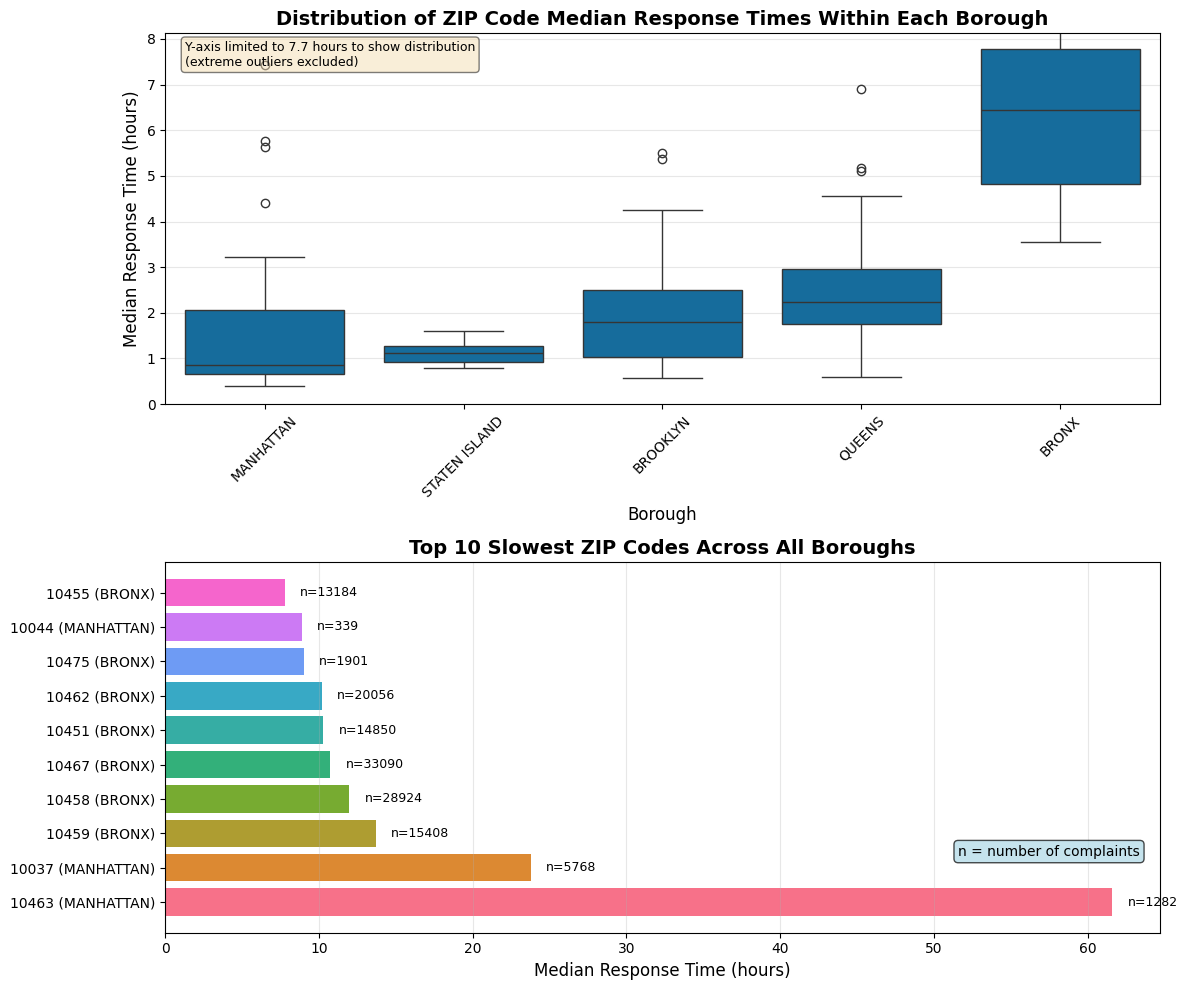

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(2, 1, figsize=(12, 10))

# plot 1: box plot of median response times by borough (showing ZIP code variation)
borough_order = rq2_summary.groupby("borough")["median_hours"].median().sort_values().index
rq2_plot = rq2_summary[rq2_summary["borough"].isin(borough_order)]

sns.boxplot(data=rq2_plot, x="borough", y="median_hours", order=borough_order, ax=axes[0])
axes[0].set_title("Distribution of ZIP Code Median Response Times Within Each Borough", fontsize=14, fontweight="bold")
axes[0].set_xlabel("Borough", fontsize=12)
axes[0].set_ylabel("Median Response Time (hours)", fontsize=12)
axes[0].tick_params(axis="x", rotation=45)
axes[0].grid(axis="y", alpha=0.3)

y_max = rq2_plot["median_hours"].quantile(0.95)
axes[0].set_ylim(0, y_max * 1.05) 
axes[0].text(0.02, 0.98, f"Y-axis limited to {y_max:.1f} hours to show distribution\n(extreme outliers excluded)", 
             transform=axes[0].transAxes, fontsize=9, verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# plot 2: top 10 slowest ZIP codes across all boroughs
top_slow_zips = rq2_summary.nlargest(10, "median_hours")
colors = sns.color_palette("husl", len(top_slow_zips))
bars = axes[1].barh(range(len(top_slow_zips)), top_slow_zips["median_hours"], color=colors)
axes[1].set_yticks(range(len(top_slow_zips)))
axes[1].set_yticklabels([f"{row['zip_clean']} ({row['borough']})" for _, row in top_slow_zips.iterrows()])
axes[1].set_xlabel("Median Response Time (hours)", fontsize=12)
axes[1].set_title("Top 10 Slowest ZIP Codes Across All Boroughs", fontsize=14, fontweight="bold")
axes[1].grid(axis="x", alpha=0.3)

for i, (_, row) in enumerate(top_slow_zips.iterrows()):
    axes[1].text(row["median_hours"] + 1, i, f"n={int(row['count'])}", va="center", fontsize=9)

axes[1].text(0.98, 0.2, "n = number of complaints", transform=axes[1].transAxes, 
             fontsize=10, horizontalalignment='right', verticalalignment='bottom',
             bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.7))

plt.tight_layout()
plt.savefig(PROJECT_ROOT / "figures" / "rq2_zip_response_times.png", dpi=300, bbox_inches="tight")
plt.show()

In [ ]:
#!python3 -m pip install --upgrade kaleido

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9/9 [kaleido]m6/9 [choreographer]


The next cell creates an interactive geographic map showing ZIP code-level response times. I aggregate complaints by ZIP code and plot them on a map, using color to represent median response time and size to represent complaint volume. This helps identify spatial clusters of slow responses.


In [13]:
import plotly.express as px
import plotly.graph_objects as go

# aggregating complaints by ZIP code with geographic coordinates using the latitude and longitude from the original data
df_rq2_map = df_rq2[df_rq2["latitude"].notna() & df_rq2["longitude"].notna()].copy()
df_rq2_map["latitude"] = pd.to_numeric(df_rq2_map["latitude"], errors="coerce")
df_rq2_map["longitude"] = pd.to_numeric(df_rq2_map["longitude"], errors="coerce")
df_rq2_map = df_rq2_map[df_rq2_map["latitude"].notna() & df_rq2_map["longitude"].notna()].copy()

# computing ZIP code centroids and response time statistics
zip_agg = (
    df_rq2_map.groupby(["zip_clean", "borough"])
    .agg({
        "latitude": "median",
        "longitude": "median",
        "response_time_days": ["median", "count", "mean"]
    })
    .reset_index()
)
zip_agg.columns = ["zip_clean", "borough", "lat", "lon", "median_days", "count", "mean_days"]
zip_agg["median_hours"] = zip_agg["median_days"] * 24
zip_agg["mean_hours"] = zip_agg["mean_days"] * 24

# filtering to ZIP codes with sufficient data
zip_agg = zip_agg[zip_agg["count"] >= min_complaints].copy()

print(f"ZIP codes with geographic data and at least {min_complaints} complaints: {len(zip_agg)}")
print(f"\nResponse time range: {zip_agg['median_hours'].min():.2f} to {zip_agg['median_hours'].max():.2f} hours")

color_percentile = 0.95
color_max = zip_agg["median_hours"].quantile(color_percentile)
print(f"Using color scale range: 0 to {color_max:.1f} hours (95th percentile)")

fig = px.scatter_mapbox(
    zip_agg,
    lat="lat",
    lon="lon",
    size="count",
    color="median_hours",
    color_continuous_scale="Plasma_r",
    range_color=[0, color_max],
    hover_name="zip_clean",
    hover_data={
        "borough": True,
        "median_hours": ":.2f",
        "mean_hours": ":.2f",
        "count": ":,",
        "lat": False,
        "lon": False
    },
    size_max=30,
    zoom=10,
    height=700,
    title="ZIP Code Response Time Hotspots: Median Response Time by ZIP Code (2024)"
)

fig.update_layout(
    mapbox_style="open-street-map",
    margin={"r": 0, "t": 50, "l": 0, "b": 0},
    coloraxis_colorbar=dict(title="Median Response<br>Time (hours)")
)

fig.write_html(str(PROJECT_ROOT / "figures" / "rq2_zip_geographic_hotspots.html"))
print(f"\nInteractive map saved to: figures/rq2_zip_geographic_hotspots.html")
fig.show()

try:
    fig.write_image(str(PROJECT_ROOT / "figures" / "rq2_zip_geographic_hotspots.png"), width=1200, height=700)
    print(f"Static map saved to: figures/rq2_zip_geographic_hotspots.png")
except ValueError as e:
    if "kaleido" in str(e).lower():
        print("Note: Static image not saved. To enable static image export, install kaleido:")
        print("  pip install --upgrade kaleido")
        print("  Then restart your Jupyter kernel.")
    else:
        raise

ZIP codes with geographic data and at least 50 complaints: 186

Response time range: 0.39 to 61.60 hours
Using color scale range: 0 to 7.8 hours (95th percentile)

Interactive map saved to: figures/rq2_zip_geographic_hotspots.html


/var/folders/fm/jlzb_kj54_5287x6fny22lzr0000gn/T/ipykernel_3301/3435156611.py:34: DeprecationWarning:

*scatter_mapbox* is deprecated! Use *scatter_map* instead. Learn more at: https://plotly.com/python/mapbox-to-maplibre/



Note: Static image not saved. To enable static image export, install kaleido:
  pip install --upgrade kaleido
  Then restart your Jupyter kernel.


The next cell performs statistical tests to determine if response times vary significantly across ZIP codes within each borough. I use the Kruskal-Wallis test, which is appropriate for comparing multiple groups (ZIP codes) when the data may not be normally distributed.


In [14]:
from scipy.stats import kruskal

# performing Kruskal-Wallis tests for each borough testing whether response times differ significantly across ZIP codes within each borough
print("Kruskal-Wallis Tests: Do response times vary significantly across ZIP codes within each borough?\n")

kruskal_results = {}

for borough in sorted(df_rq2["borough"].unique()):
    borough_data = df_rq2[df_rq2["borough"] == borough].copy()
    
    # filtering to ZIP codes with at least 50 complaints for statistical reliability
    zip_counts = borough_data["zip_clean"].value_counts()
    valid_zips = zip_counts[zip_counts >= 50].index
    borough_data = borough_data[borough_data["zip_clean"].isin(valid_zips)].copy()
    
    if len(valid_zips) < 2:
        print(f"{borough}: Insufficient ZIP codes for comparison (need at least 2 with 50+ complaints)")
        continue
    
    # preparing data for Kruskal-Wallis: list of response time arrays, one per ZIP code
    zip_groups = [borough_data[borough_data["zip_clean"] == zip_code]["response_time_days"].values 
                   for zip_code in valid_zips]
    
    statistic, p_value = kruskal(*zip_groups)
    
    kruskal_results[borough] = {
        "statistic": statistic,
        "p_value": p_value,
        "n_zips": len(valid_zips),
        "n_complaints": len(borough_data)
    }
    
    significance = "***" if p_value < 0.001 else "**" if p_value < 0.01 else "*" if p_value < 0.05 else "ns"
    print(f"{borough}:")
    print(f"  ZIP codes compared: {len(valid_zips)}")
    print(f"  Total complaints: {len(borough_data):,}")
    print(f"  Kruskal-Wallis statistic: {statistic:.2f}")
    print(f"  p-value: {p_value:.6f} {significance}")
    print(f"  Interpretation: {'Significant variation' if p_value < 0.05 else 'No significant variation'} across ZIP codes")
    print()

print("Significance levels: *** p<0.001, ** p<0.01, * p<0.05, ns = not significant")


Kruskal-Wallis Tests: Do response times vary significantly across ZIP codes within each borough?

BRONX:
  ZIP codes compared: 25
  Total complaints: 485,953
  Kruskal-Wallis statistic: 11901.86
  p-value: 0.000000 ***
  Interpretation: Significant variation across ZIP codes

BROOKLYN:
  ZIP codes compared: 38
  Total complaints: 580,672
  Kruskal-Wallis statistic: 46995.26
  p-value: 0.000000 ***
  Interpretation: Significant variation across ZIP codes

MANHATTAN:
  ZIP codes compared: 50
  Total complaints: 328,644
  Kruskal-Wallis statistic: 30907.78
  p-value: 0.000000 ***
  Interpretation: Significant variation across ZIP codes

QUEENS:
  ZIP codes compared: 61
  Total complaints: 428,402
  Kruskal-Wallis statistic: 19171.61
  p-value: 0.000000 ***
  Interpretation: Significant variation across ZIP codes

STATEN ISLAND:
  ZIP codes compared: 12
  Total complaints: 44,584
  Kruskal-Wallis statistic: 1315.41
  p-value: 0.000000 ***
  Interpretation: Significant variation across ZIP 

The next cell analyzes complaint-type interactions with ZIP codes. I identify which ZIP codes are slow for specific complaint types, helping understand whether certain neighborhoods face systematic delays for particular types of issues.


In [15]:
min_complaints_per_type = 20  # minimum complaints per complaint type per ZIP code

# computing median response time by ZIP code and complaint type
zip_complaint_stats = (
    df_rq2.groupby(["zip_clean", "borough", "complaint_type"])["response_time_days"]
    .agg(["count", "median", "mean"])
    .reset_index()
)

# filtering to ZIP-code/complaint-type combinations with sufficient data
zip_complaint_stats = zip_complaint_stats[zip_complaint_stats["count"] >= min_complaints_per_type].copy()
zip_complaint_stats["median_hours"] = zip_complaint_stats["median"] * 24
zip_complaint_stats["mean_hours"] = zip_complaint_stats["mean"] * 24

print(f"ZIP code-complaint type combinations with at least {min_complaints_per_type} complaints: {len(zip_complaint_stats)}")
print("\n")
print("Slowest ZIP codes for each complaint type (top 3 per type):")

# finding slowest ZIP codes for each complaint type
for complaint_type in sorted(zip_complaint_stats["complaint_type"].unique()):
    complaint_data = zip_complaint_stats[zip_complaint_stats["complaint_type"] == complaint_type]
    top_slow = complaint_data.nlargest(3, "median_hours")
    
    print(f"\n{complaint_type}:")
    for _, row in top_slow.iterrows():
        print(f"  ZIP {row['zip_clean']} ({row['borough']}): {row['median_hours']:.2f} hours (median), "
              f"{int(row['count'])} complaints")

print("\n")
print("\nIdentifying ZIP codes that are consistently slow across multiple complaint types:")

# identifying ZIP codes that appear in top quartile for multiple complaint types
zip_complaint_stats["is_slow"] = False

for complaint_type in zip_complaint_stats["complaint_type"].unique():
    complaint_data = zip_complaint_stats[zip_complaint_stats["complaint_type"] == complaint_type]
    threshold = complaint_data["median_hours"].quantile(0.75)
    zip_complaint_stats.loc[
        (zip_complaint_stats["complaint_type"] == complaint_type) & 
        (zip_complaint_stats["median_hours"] >= threshold),
        "is_slow"
    ] = True

# counting how many complaint types each ZIP code is slow for
zip_slow_counts = (
    zip_complaint_stats[zip_complaint_stats["is_slow"]]
    .groupby(["zip_clean", "borough"])
    .size()
    .reset_index(name="n_slow_types")
)

# total complaint types analyzed per ZIP code
zip_total_types = (
    zip_complaint_stats.groupby(["zip_clean", "borough"])
    .size()
    .reset_index(name="n_total_types")
)

zip_slow_summary = zip_total_types.merge(zip_slow_counts, on=["zip_clean", "borough"], how="left")
zip_slow_summary["n_slow_types"] = zip_slow_summary["n_slow_types"].fillna(0).astype(int)
zip_slow_summary["pct_slow"] = (zip_slow_summary["n_slow_types"] / zip_slow_summary["n_total_types"] * 100).round(1)

print("\nZIP codes slow for multiple complaint types (top 10):")
multi_slow = zip_slow_summary[zip_slow_summary["n_slow_types"] >= 2].nlargest(10, "n_slow_types")
for _, row in multi_slow.iterrows():
    print(f"  ZIP {row['zip_clean']} ({row['borough']}): "
          f"slow for {int(row['n_slow_types'])}/{int(row['n_total_types'])} complaint types ({row['pct_slow']:.1f}%)")

ZIP code-complaint type combinations with at least 20 complaints: 1707


Slowest ZIP codes for each complaint type (top 3 per type):

Abandoned Vehicle:
  ZIP 10464 (BRONX): 8.90 hours (median), 77 complaints
  ZIP 10472 (BRONX): 7.55 hours (median), 207 complaints
  ZIP 10473 (BRONX): 6.81 hours (median), 533 complaints

Blocked Driveway:
  ZIP 10465 (BRONX): 4.83 hours (median), 877 complaints
  ZIP 10461 (BRONX): 4.66 hours (median), 1679 complaints
  ZIP 10475 (BRONX): 4.44 hours (median), 156 complaints

HEAT/HOT WATER:
  ZIP 10044 (MANHATTAN): 66.22 hours (median), 73 complaints
  ZIP 11239 (BROOKLYN): 65.21 hours (median), 495 complaints
  ZIP 10309 (STATEN ISLAND): 55.34 hours (median), 27 complaints

Illegal Parking:
  ZIP 10475 (BRONX): 5.67 hours (median), 708 complaints
  ZIP 10464 (BRONX): 5.29 hours (median), 382 complaints
  ZIP 10465 (BRONX): 5.28 hours (median), 3528 complaints

Noise - Commercial:
  ZIP 10470 (BRONX): 3.32 hours (median), 75 complaints
  ZIP 10464 (BR

The next cell creates a visualization showing complaint-type interactions with ZIP codes, highlighting which ZIP codes are slow for specific complaint types.


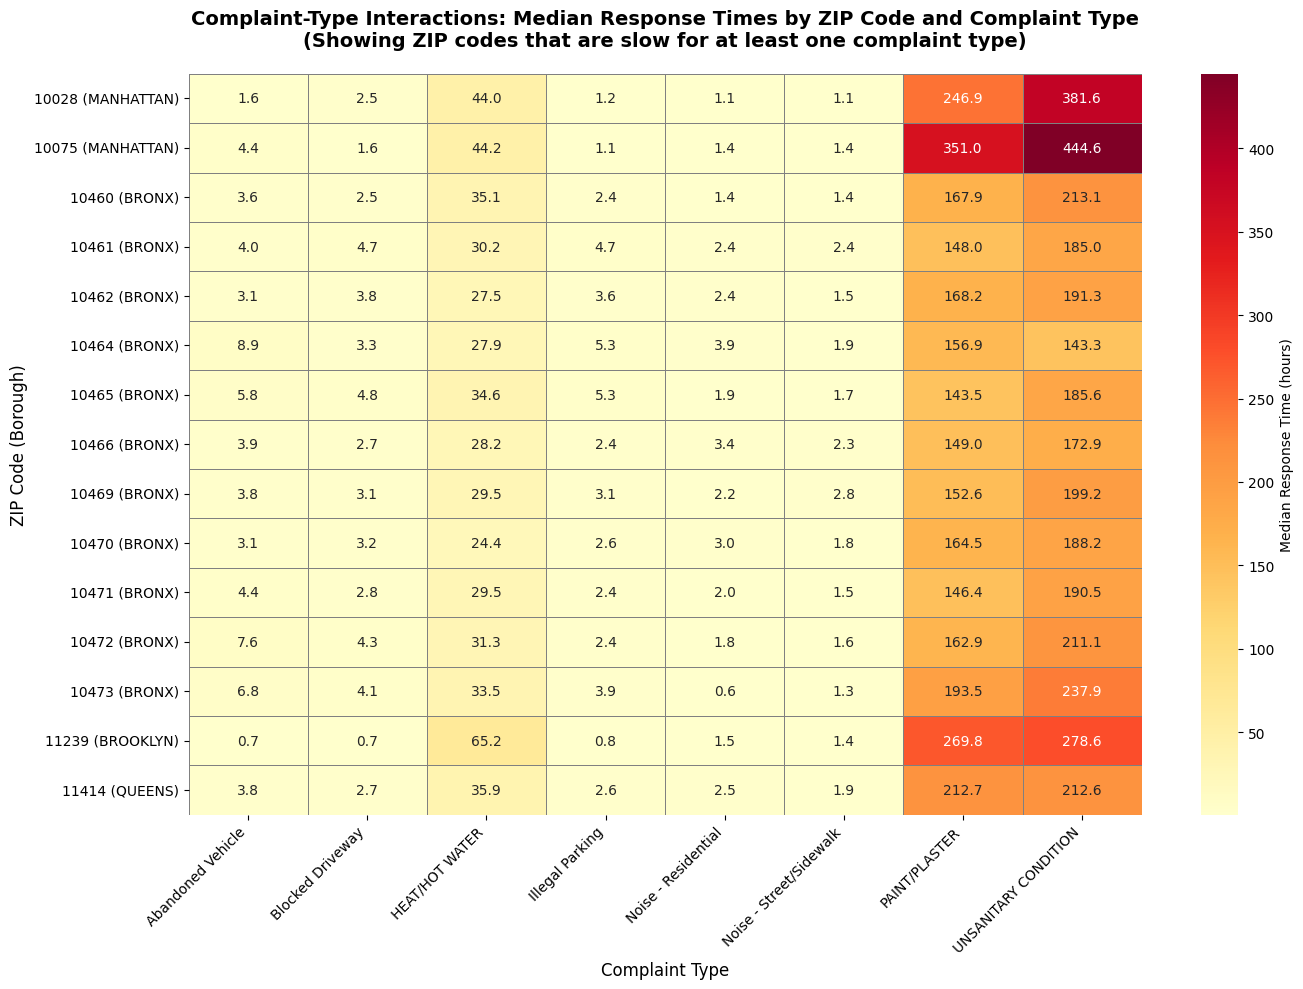

In [16]:
# creating a heatmap showing median response times by ZIP code and complaint type focusing on ZIP codes that are slow for at least one complaint type
slow_zips = zip_slow_summary[zip_slow_summary["n_slow_types"] >= 1]["zip_clean"].unique()
zip_complaint_plot = zip_complaint_stats[zip_complaint_stats["zip_clean"].isin(slow_zips)].copy()

# selecting top complaint types and top slow ZIP codes for visualization
top_complaints = zip_complaint_plot["complaint_type"].value_counts().head(8).index
top_slow_zips_viz = zip_slow_summary.nlargest(15, "n_slow_types")["zip_clean"].values

zip_complaint_plot = zip_complaint_plot[
    (zip_complaint_plot["complaint_type"].isin(top_complaints)) &
    (zip_complaint_plot["zip_clean"].isin(top_slow_zips_viz))
].copy()

heatmap_data = zip_complaint_plot.pivot_table(
    values="median_hours",
    index="zip_clean",
    columns="complaint_type",
    aggfunc="mean"
)

zip_borough_map = zip_complaint_plot[["zip_clean", "borough"]].drop_duplicates().set_index("zip_clean")["borough"]
heatmap_data.index = [f"{zip} ({zip_borough_map[zip]})" for zip in heatmap_data.index]

fig, ax = plt.subplots(figsize=(14, 10))
sns.heatmap(
    heatmap_data,
    annot=True,
    fmt=".1f",
    cmap="YlOrRd",
    cbar_kws={"label": "Median Response Time (hours)"},
    ax=ax,
    linewidths=0.5,
    linecolor="gray"
)
ax.set_title("Complaint-Type Interactions: Median Response Times by ZIP Code and Complaint Type\n"
             "(Showing ZIP codes that are slow for at least one complaint type)",
             fontsize=14, fontweight="bold", pad=20)
ax.set_xlabel("Complaint Type", fontsize=12)
ax.set_ylabel("ZIP Code (Borough)", fontsize=12)
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig(PROJECT_ROOT / "figures" / "rq2_complaint_type_interactions.png", dpi=300, bbox_inches="tight")
plt.show()

### RQ2 Findings and Discussion

The statistical tests confirm that ZIP code differences are real, not random. The Kruskal-Wallis tests show highly significant variation in all 5 boroughs, meaning some neighborhoods consistently wait longer than others, even within the same borough.

The box plots show clear patterns. Bronx ZIP codes have the slowest typical responses and the widest spread, with most areas taking around 6 hours and some over 10. Manhattan shows the most extreme variation: most ZIP codes are fast, but a few outliers push medians to over 60 hours. Brooklyn, where I spent my summer, falls in the middle, with most areas around two hours but a few closer to five. Queens and Staten Island are generally faster and more consistent, though they still show meaningful differences between neighborhoods.

The geographic map makes these patterns visible. Dark purple clusters appear in upper Manhattan and parts of the Bronx, matching the slowest ZIP codes from the statistical analysis. These clusters suggest systemic issues rather than isolated cases. The map also shows how quickly conditions can change: neighborhoods just blocks apart can have very different response times, which aligns with what I noticed during my summer in Brooklyn.

The complaint-type heatmap reveals 2 patterns: 
- First, some complaint types are slow almost everywhere. Paint and plaster issues and unsanitary conditions take weeks in many neighborhoods, regardless of borough. This suggests citywide resource or process challenges for these types. 
- Second, some ZIP codes are slow across many complaint types, appearing in the slowest quartile for 7 out of 10 types. These areas face broader service delivery issues. Other neighborhoods are fast for most complaints but slow for specific types, pointing to localized problems like infrastructure gaps or agency capacity constraints. 
The heatmap makes it clear that both location and complaint type matter, and that some neighborhoods need targeted support for specific issues while others need broader service improvements.

## Research Question 3: Do digital channels lead to faster responses than phone reports, and which complaint types rely most on phone reporting?

This question explores whether the channel used to report a complaint affects response time, and whether certain complaint types face access barriers through phone-heavy reporting. We will look at 3 parts: 
- (a) For the same complaint types within the same borough, do digital channels (app or web) receive faster responses than phone reports? 
- (b) Which complaint types rely most on phone reporting versus digital channels? 
- (c) Do phone-heavy complaint types experience systematically slower closure times compared to digitally reported complaints? I compare response times across Phone, Web, and App channels while controlling for complaint type and borough, perform statistical tests to identify significant differences, and analyze channel preferences by complaint type to identify potential access barriers.

The next cell prepares the data for RQ3 analysis by filtering to rows with valid channel types and ensuring we have sufficient data for comparisons across channels, complaint types, and boroughs.

In [17]:
if 'df' not in globals():
    try:
        import pandas as pd
        from pathlib import Path
        import numpy as np
    except ImportError as e:
        raise ImportError(f"Required imports not found: {e}. Please run the setup cells first.")
    
    PROJECT_ROOT = Path('..').resolve()
    processed_path = PROJECT_ROOT / 'data' / 'processed' / 'nyc311_2024_cleaned.parquet'
    sample_path = PROJECT_ROOT / 'data' / 'sample' / 'nyc311_2024_sample.parquet'
    
    if processed_path.exists():
        print(f"Loading cleaned data from {processed_path}")
        df = pd.read_parquet(processed_path)
    elif sample_path.exists():
        print(f"WARNING: Full dataset not found. Loading SAMPLE dataset from {sample_path}")
        print("Results will be illustrative only.")
        df = pd.read_parquet(sample_path)
    else:
        raise FileNotFoundError(f"Neither full dataset ({processed_path}) nor sample dataset ({sample_path}) found.")
    
    print(f"Loaded {len(df):,} rows and {len(df.columns)} columns\n")

df_rq3 = df[df["borough"] != "Unspecified"].copy()

print("Channel distribution:")
print(df_rq3["open_data_channel_type"].value_counts())
print(f"\nTotal rows for RQ3 analysis: {len(df_rq3):,}")
print(f"Complaint types: {df_rq3['complaint_type'].nunique()}")
print(f"Boroughs: {df_rq3['borough'].nunique()}")

Channel distribution:
open_data_channel_type
Web      758624
App      561829
Phone    548800
Name: count, dtype: int64

Total rows for RQ3 analysis: 1,869,253
Complaint types: 10
Boroughs: 5



part (a): comparing response times across channels (controlling for complaint type and borough)

In [18]:
# computing median response times by channel, complaint type, and borough
rq3a_summary = (
    df_rq3.groupby(["open_data_channel_type", "complaint_type", "borough"])["response_time_days"]
    .agg(["count", "median", "mean"])
    .reset_index()
)

rq3a_summary["median_hours"] = rq3a_summary["median"] * 24
rq3a_summary["mean_hours"] = rq3a_summary["mean"] * 24

# filtering to combinations with at least 20 complaints for reliability
min_complaints_rq3 = 20
rq3a_summary = rq3a_summary[rq3a_summary["count"] >= min_complaints_rq3].copy()

print(f"Channel-complaint-borough combinations with at least {min_complaints_rq3} complaints: {len(rq3a_summary)}")
print("\n")
print("Overall median response times by channel (across all complaint types and boroughs):")
overall_by_channel = df_rq3.groupby("open_data_channel_type")["response_time_days"].median() * 24
for channel, median_hours in overall_by_channel.items():
    print(f"{channel}: {median_hours:.2f} hours")

print("\n")
print("Median response times by channel and complaint type (aggregated across boroughs):")
channel_complaint = (
    rq3a_summary.groupby(["open_data_channel_type", "complaint_type"])["median_hours"]
    .mean()
    .reset_index()
    .pivot(index="complaint_type", columns="open_data_channel_type", values="median_hours")
)
print(channel_complaint.round(2))

# checking for missing App data
print("Note: Missing App data indicates complaint types not commonly reported via app:")
missing_app = []
for complaint_type in channel_complaint.index:
    if pd.isna(channel_complaint.loc[complaint_type, "App"]):
        phone_val = channel_complaint.loc[complaint_type, "Phone"] if not pd.isna(channel_complaint.loc[complaint_type, "Phone"]) else None
        web_val = channel_complaint.loc[complaint_type, "Web"] if not pd.isna(channel_complaint.loc[complaint_type, "Web"]) else None
        phone_str = f"{phone_val:.1f}h" if phone_val is not None else "N/A"
        web_str = f"{web_val:.1f}h" if web_val is not None else "N/A"
        print(f"{complaint_type}: No App data (Phone: {phone_str}, Web: {web_str})")
        missing_app.append(complaint_type)

if len(missing_app) == 0:
    print("All complaint types have App data available.")

Channel-complaint-borough combinations with at least 20 complaints: 135


Overall median response times by channel (across all complaint types and boroughs):
App: 1.52 hours
Phone: 8.17 hours
Web: 1.82 hours


Median response times by channel and complaint type (aggregated across boroughs):
open_data_channel_type    App  Phone    Web
complaint_type                             
Abandoned Vehicle        2.02   2.13   1.77
Blocked Driveway         1.55   1.58   1.64
HEAT/HOT WATER          34.08  40.22  37.49
Illegal Parking          1.49   1.46   1.43
Noise - Commercial       0.71   0.72   0.72
Noise - Residential      1.15   0.82   0.76
Noise - Street/Sidewalk  0.71   0.73   0.70
PAINT/PLASTER             NaN 161.03 156.82
PLUMBING                  NaN 186.52 156.14
UNSANITARY CONDITION      NaN 205.27 246.55
Note: Missing App data indicates complaint types not commonly reported via app:
PAINT/PLASTER: No App data (Phone: 161.0h, Web: 156.8h)
PLUMBING: No App data (Phone: 186.5h, Web: 1

The next cell creates visualizations showing channel differences in response times. I create a heatmap showing median response times by channel and complaint type, and box plots comparing distributions across channels.

/var/folders/fm/jlzb_kj54_5287x6fny22lzr0000gn/T/ipykernel_3301/3311013188.py:32: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




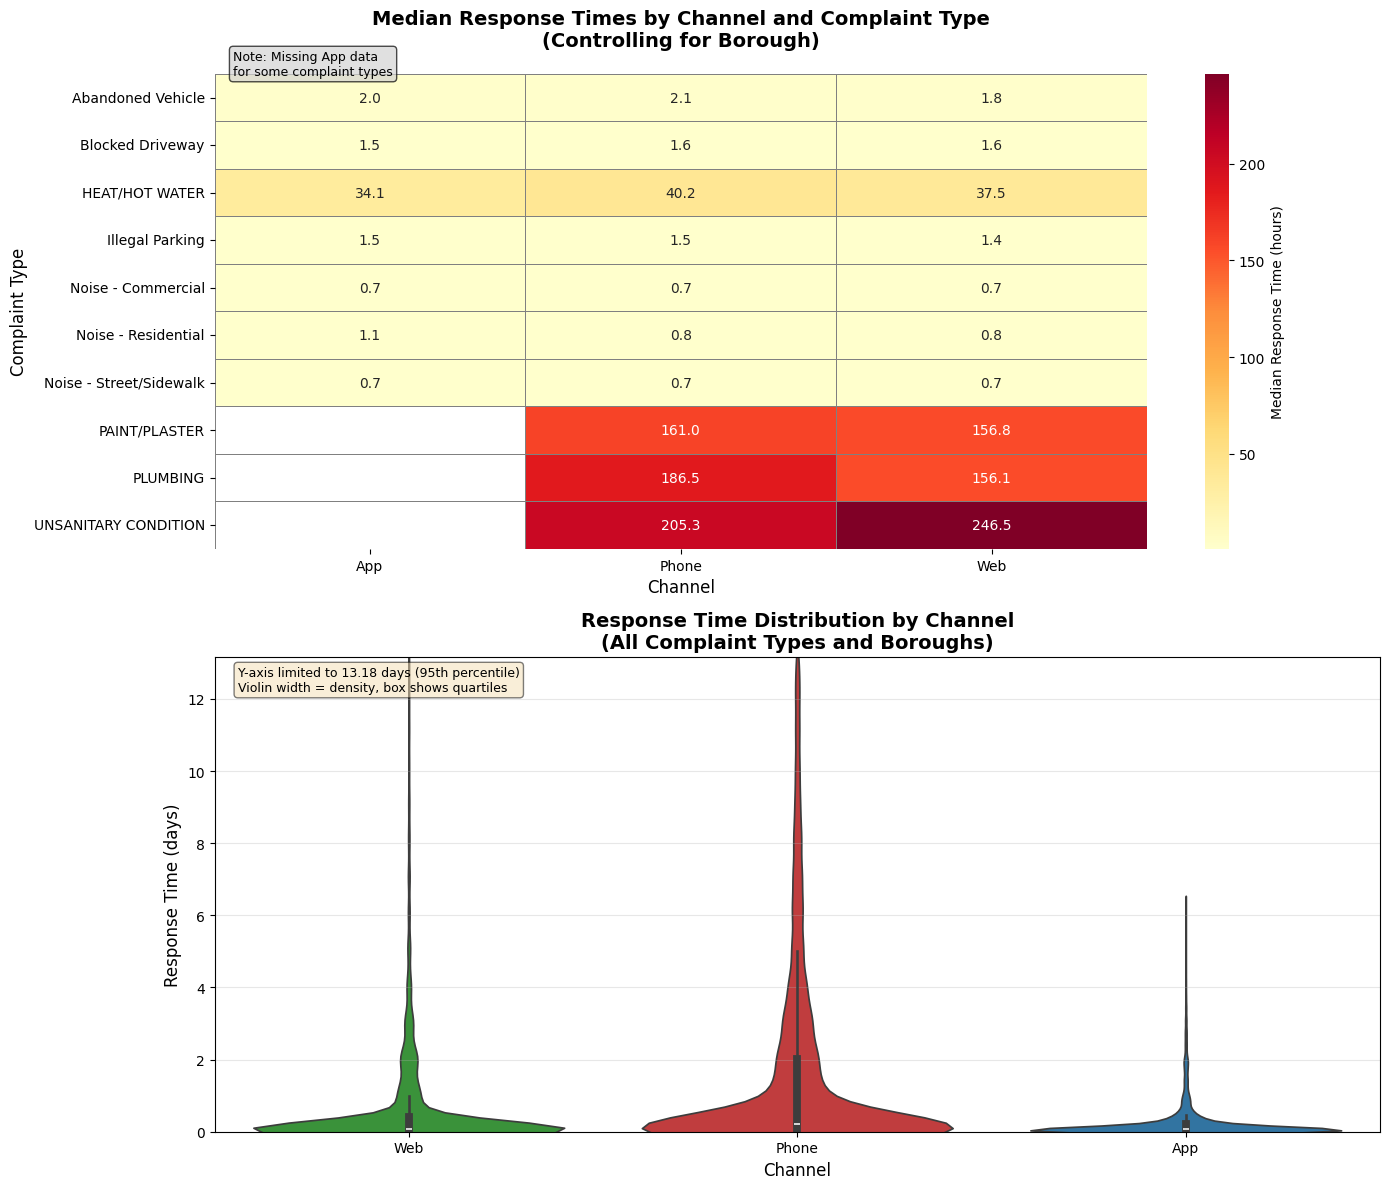

In [19]:
fig, axes = plt.subplots(2, 1, figsize=(14, 12))

# plot 1: heatmap of median response times by channel and complaint type
heatmap_data = channel_complaint.copy()
mask = heatmap_data.isna()
sns.heatmap(
    heatmap_data,
    annot=True,
    fmt=".1f",
    cmap="YlOrRd",
    cbar_kws={"label": "Median Response Time (hours)"},
    ax=axes[0],
    linewidths=0.5,
    linecolor="gray",
    mask=mask
)
axes[0].set_title("Median Response Times by Channel and Complaint Type\n(Controlling for Borough)", 
                  fontsize=14, fontweight="bold", pad=20)
axes[0].set_xlabel("Channel", fontsize=12)
axes[0].set_ylabel("Complaint Type", fontsize=12)
plt.setp(axes[0].get_xticklabels(), rotation=0)
plt.setp(axes[0].get_yticklabels(), rotation=0)
axes[0].text(0.02, 1.05, "Note: Missing App data\nfor some complaint types", 
             transform=axes[0].transAxes, fontsize=9, verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='lightgray', alpha=0.7))

# plot 2: violin plots to better show distribution shapes (especially for Web and App)
df_rq3_sample = df_rq3.sample(n=min(50000, len(df_rq3)), random_state=42)
y_max = df_rq3_sample["response_time_days"].quantile(0.95)
df_rq3_viz = df_rq3_sample[df_rq3_sample["response_time_days"] <= y_max].copy()

sns.violinplot(
    data=df_rq3_viz,
    x="open_data_channel_type",
    y="response_time_days",
    ax=axes[1],
    inner="box",  
    palette=["#2ca02c", "#d62728", "#1f77b4"] 
)
axes[1].set_title("Response Time Distribution by Channel\n(All Complaint Types and Boroughs)", 
                  fontsize=14, fontweight="bold")
axes[1].set_xlabel("Channel", fontsize=12)
axes[1].set_ylabel("Response Time (days)", fontsize=12)
axes[1].set_ylim(0, y_max)
axes[1].text(0.02, 0.98, f"Y-axis limited to {y_max:.2f} days (95th percentile)\nViolin width = density, box shows quartiles", 
             transform=axes[1].transAxes, fontsize=9, verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
axes[1].grid(axis="y", alpha=0.3)

plt.tight_layout()
plt.savefig(PROJECT_ROOT / "figures" / "rq3_channel_comparison.png", dpi=300, bbox_inches="tight")
plt.show()

installing scikit-posthocs library

In [ ]:
#!python3 -m pip install seaborn matplotlib plotly scikit-learn pyarrow scikit-posthocs

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.0/10.0 MB 10.0 MB/s  0:00:01eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3/3 [scikit-posthocs] [statsmodels]



performing Kruskal-Wallis tests for each complaint type

In [22]:
from scipy.stats import kruskal
from scikit_posthocs import posthoc_dunn

# testing whether response times differ significantly across channels (controlling for borough)
print("Kruskal-Wallis Tests: Do response times differ significantly across channels within each complaint type?")
print("(Controlling for borough)\n")

kruskal_results_rq3 = {}

for complaint_type in sorted(df_rq3["complaint_type"].unique()):
    complaint_data = df_rq3[df_rq3["complaint_type"] == complaint_type].copy()
    
    # grouping by channel (aggregating across boroughs for this test)
    channel_counts = complaint_data["open_data_channel_type"].value_counts()
    valid_channels = channel_counts[channel_counts >= 20].index
    
    if len(valid_channels) < 2:
        continue  
    
    channel_groups = [
        complaint_data[complaint_data["open_data_channel_type"] == channel]["response_time_days"].values
        for channel in valid_channels
    ]
    
    statistic, p_value = kruskal(*channel_groups)
    
    kruskal_results_rq3[complaint_type] = {
        "statistic": statistic,
        "p_value": p_value,
        "channels": list(valid_channels),
        "n_complaints": len(complaint_data)
    }
    
    significance = "***" if p_value < 0.001 else "**" if p_value < 0.01 else "*" if p_value < 0.05 else "ns"
    print(f"{complaint_type}:")
    print(f"  Channels compared: {', '.join(valid_channels)}")
    print(f"  Total complaints: {len(complaint_data):,}")
    print(f"  Kruskal-Wallis statistic: {statistic:.2f}")
    print(f"  p-value: {p_value:.6f} {significance}")
    print(f"  Interpretation: {'Significant difference' if p_value < 0.05 else 'No significant difference'} across channels")
    print()

print("Significance levels: *** p<0.001, ** p<0.01, * p<0.05, ns = not significant")

Kruskal-Wallis Tests: Do response times differ significantly across channels within each complaint type?
(Controlling for borough)

Abandoned Vehicle:
  Channels compared: Web, Phone, App
  Total complaints: 70,320
  Kruskal-Wallis statistic: 1183.60
  p-value: 0.000000 ***
  Interpretation: Significant difference across channels

Blocked Driveway:
  Channels compared: Phone, Web, App
  Total complaints: 170,188
  Kruskal-Wallis statistic: 15.62
  p-value: 0.000406 ***
  Interpretation: Significant difference across channels

HEAT/HOT WATER:
  Channels compared: Web, Phone, App
  Total complaints: 261,748
  Kruskal-Wallis statistic: 1351.91
  p-value: 0.000000 ***
  Interpretation: Significant difference across channels

Illegal Parking:
  Channels compared: App, Web, Phone
  Total complaints: 505,696
  Kruskal-Wallis statistic: 1047.89
  p-value: 0.000000 ***
  Interpretation: Significant difference across channels

Noise - Commercial:
  Channels compared: Web, App, Phone
  Total comp

The next cell addresses part (b) of RQ3: analyzing which complaint types rely most on phone reporting versus digital channels. I compute the percentage of complaints reported through each channel for each complaint type.

In [23]:
# part (b): analyzing channel preference by complaint type
# computing percentage of complaints by channel for each complaint type
channel_preference = (
    df_rq3.groupby(["complaint_type", "open_data_channel_type"])
    .size()
    .reset_index(name="count")
)

channel_preference_pct = channel_preference.pivot(
    index="complaint_type",
    columns="open_data_channel_type",
    values="count"
).fillna(0)

channel_preference_pct = channel_preference_pct.div(channel_preference_pct.sum(axis=1), axis=0) * 100

# identifying phone-heavy complaint types (more than 50% phone)
channel_preference_pct["phone_pct"] = channel_preference_pct.get("Phone", 0)
channel_preference_pct["digital_pct"] = channel_preference_pct.get("Web", 0) + channel_preference_pct.get("App", 0)
channel_preference_pct = channel_preference_pct.sort_values("phone_pct", ascending=False)

print("Channel preference by complaint type (percentage):")
print(channel_preference_pct[["Phone", "Web", "App", "phone_pct", "digital_pct"]].round(1))

print("\n")
print("Phone-heavy complaint types (more than 50% phone):")
phone_heavy = channel_preference_pct[channel_preference_pct["phone_pct"] > 50]
if len(phone_heavy) > 0:
    for complaint_type, row in phone_heavy.iterrows():
        print(f"{complaint_type}: {row['phone_pct']:.1f}% phone, {row['digital_pct']:.1f}% digital")
else:
    print("No complaint types are phone-heavy (all have <50% phone reporting)")

print("\n")
print("Digital-heavy complaint types (more than 50% digital):")
digital_heavy = channel_preference_pct[channel_preference_pct["digital_pct"] > 50]
for complaint_type, row in digital_heavy.iterrows():
    print(f"{complaint_type}: {row['digital_pct']:.1f}% digital, {row['phone_pct']:.1f}% phone")

Channel preference by complaint type (percentage):
open_data_channel_type   Phone   Web   App  phone_pct  digital_pct
complaint_type                                                    
PAINT/PLASTER            72.00 28.00  0.00      72.00        28.00
PLUMBING                 66.80 33.20  0.00      66.80        33.20
UNSANITARY CONDITION     63.80 36.20  0.00      63.80        36.20
Blocked Driveway         48.50 27.00 24.50      48.50        51.50
HEAT/HOT WATER           35.10 46.30 18.70      35.10        64.90
Abandoned Vehicle        31.40 41.30 27.30      31.40        68.60
Illegal Parking          17.70 35.40 46.80      17.70        82.30
Noise - Residential      16.90 50.80 32.20      16.90        83.10
Noise - Commercial       14.50 48.20 37.40      14.50        85.50
Noise - Street/Sidewalk  13.10 45.60 41.30      13.10        86.90


Phone-heavy complaint types (more than 50% phone):
PAINT/PLASTER: 72.0% phone, 28.0% digital
PLUMBING: 66.8% phone, 33.2% digital
UNSANITARY CO

The next cell creates visualizations for channel preference analysis, showing which complaint types rely on phone versus digital channels.

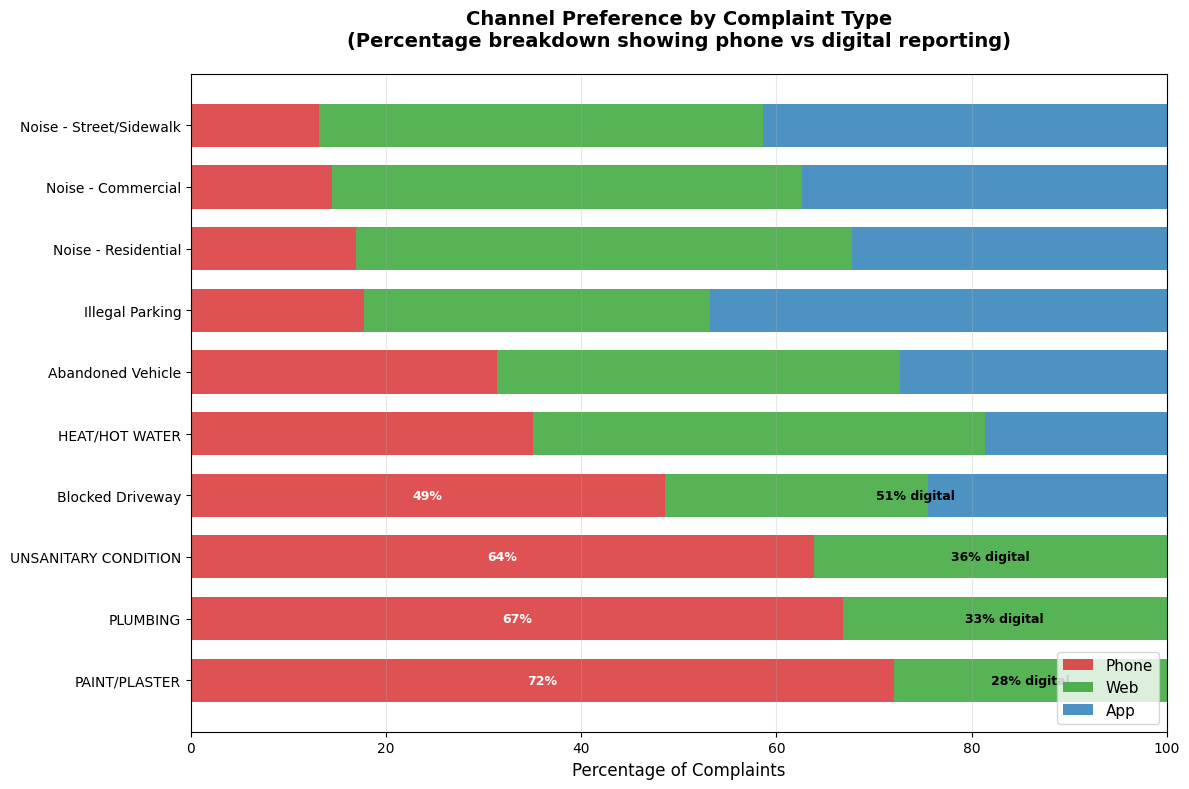


Visualization saved to: figures/rq3_channel_preference.png


In [24]:
fig, ax = plt.subplots(figsize=(12, 8))

# sorting by phone percentage (descending) to show phone-heavy types first
plot_data = channel_preference_pct.sort_values("phone_pct", ascending=False)

x_pos = np.arange(len(plot_data))
width = 0.7

phone_vals = plot_data["Phone"].values
web_vals = plot_data["Web"].values
app_vals = plot_data["App"].values

bars1 = ax.barh(x_pos, phone_vals, width, label="Phone", color="#d62728", alpha=0.8)
bars2 = ax.barh(x_pos, web_vals, width, left=phone_vals, label="Web", color="#2ca02c", alpha=0.8)
bars3 = ax.barh(x_pos, app_vals, width, left=phone_vals + web_vals, label="App", color="#1f77b4", alpha=0.8)

ax.set_yticks(x_pos)
ax.set_yticklabels(plot_data.index, fontsize=10)
ax.set_xlabel("Percentage of Complaints", fontsize=12)
ax.set_title("Channel Preference by Complaint Type\n(Percentage breakdown showing phone vs digital reporting)", 
             fontsize=14, fontweight="bold", pad=20)
ax.set_xlim(0, 100)
ax.legend(loc="lower right", fontsize=11)
ax.grid(axis="x", alpha=0.3)

for i, (complaint_type, row) in enumerate(plot_data.iterrows()):
    if row["phone_pct"] >= 40:
        ax.text(row["phone_pct"] / 2, i, f"{row['phone_pct']:.0f}%", 
                ha="center", va="center", fontsize=9, fontweight="bold", color="white")
    if row["phone_pct"] >= 40:
        digital_total = row["digital_pct"]
        ax.text(100 - digital_total / 2, i, f"{digital_total:.0f}% digital", 
                ha="center", va="center", fontsize=9, fontweight="bold", color="black")

plt.tight_layout()
plt.savefig(PROJECT_ROOT / "figures" / "rq3_channel_preference.png", dpi=300, bbox_inches="tight")
plt.show()

print("\nVisualization saved to: figures/rq3_channel_preference.png")

The next cell addresses part (c) of RQ3: comparing response times for phone-heavy complaint types between phone and digital channels. This helps determine whether phone-heavy complaint types experience systematically slower closure times, which could indicate access barriers or workflow differences.


Part (c): Phone-heavy complaint types and their response times

Phone-heavy complaint types (≥40% phone): PAINT/PLASTER, PLUMBING, UNSANITARY CONDITION, Blocked Driveway
Response time comparison: Phone vs Digital for phone-heavy complaint types

PAINT/PLASTER:
  Phone: 164.49 hours (median), n=46,273
  Digital: 161.22 hours (median), n=17,998
  Difference: +3.28 hours (+2.0%)

PLUMBING:
  Phone: 189.81 hours (median), n=43,923
  Digital: 155.70 hours (median), n=21,844
  Difference: +34.10 hours (+21.9%)

UNSANITARY CONDITION:
  Phone: 199.61 hours (median), n=77,062
  Digital: 239.72 hours (median), n=43,637
  Difference: -40.11 hours (-16.7%)

Blocked Driveway:
  Phone: 1.81 hours (median), n=82,606
  Digital: 1.79 hours (median), n=87,582
  Difference: +0.02 hours (+1.0%)


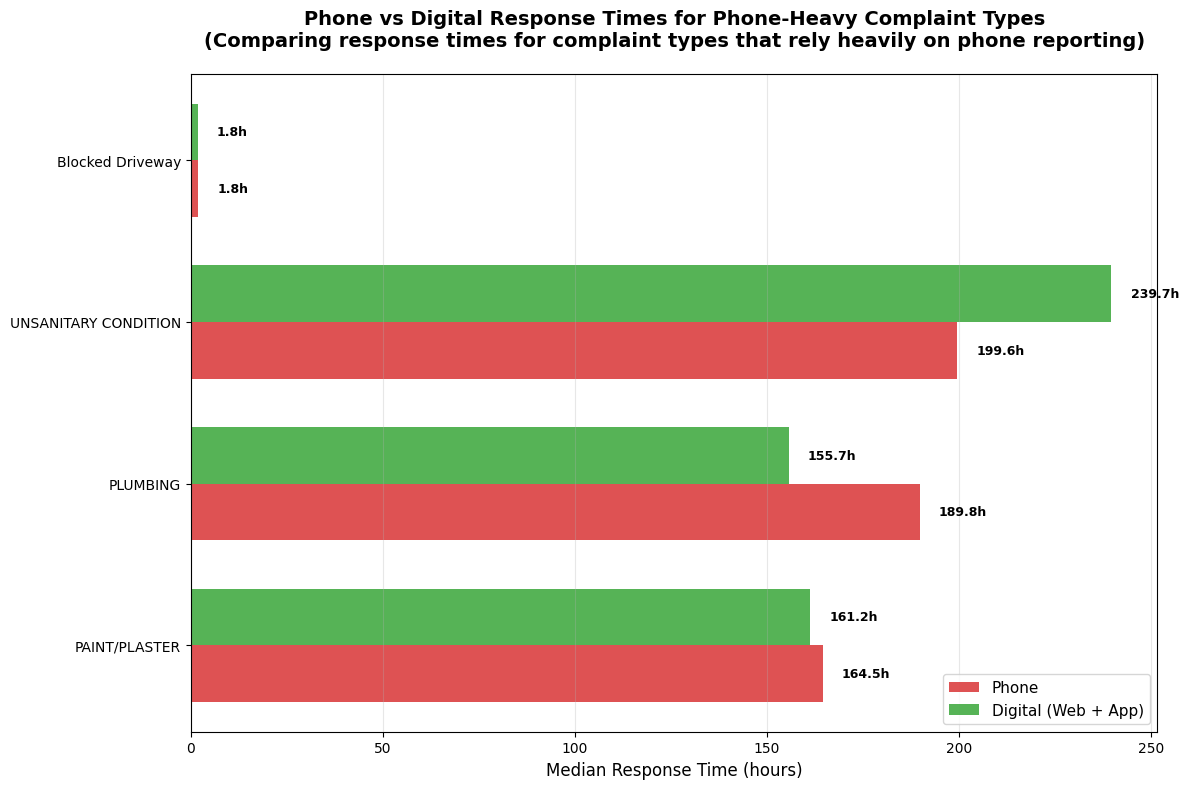



Visualization saved to: figures/rq3_phone_heavy_comparison.png


In [26]:
# part (c): comparing phone vs digital response times for phone-heavy complaint types
# identifying phone-heavy complaint types (using ≥40% threshold to include borderline cases)
phone_heavy_threshold = 40
phone_heavy_types = channel_preference_pct[channel_preference_pct["phone_pct"] >= phone_heavy_threshold].index.tolist()

print("Part (c): Phone-heavy complaint types and their response times")
print(f"\nPhone-heavy complaint types (≥{phone_heavy_threshold}% phone): {', '.join(phone_heavy_types)}")
print("Response time comparison: Phone vs Digital for phone-heavy complaint types")

# comparing phone vs digital (Web + App combined) for phone-heavy types
comparison_results = []

for complaint_type in phone_heavy_types:
    complaint_data = df_rq3[df_rq3["complaint_type"] == complaint_type].copy()
    
    # separating phone and digital (Web + App)
    phone_data = complaint_data[complaint_data["open_data_channel_type"] == "Phone"]["response_time_days"]
    digital_data = complaint_data[complaint_data["open_data_channel_type"].isin(["Web", "App"])]["response_time_days"]
    
    if len(phone_data) > 0 and len(digital_data) > 0:
        phone_median_hours = phone_data.median() * 24
        digital_median_hours = digital_data.median() * 24
        difference = phone_median_hours - digital_median_hours
        pct_diff = (difference / digital_median_hours) * 100 if digital_median_hours > 0 else 0
        
        comparison_results.append({
            "complaint_type": complaint_type,
            "phone_median_hours": phone_median_hours,
            "digital_median_hours": digital_median_hours,
            "difference": difference,
            "pct_diff": pct_diff,
            "phone_n": len(phone_data),
            "digital_n": len(digital_data)
        })
        
        print(f"\n{complaint_type}:")
        print(f"  Phone: {phone_median_hours:.2f} hours (median), n={len(phone_data):,}")
        print(f"  Digital: {digital_median_hours:.2f} hours (median), n={len(digital_data):,}")
        print(f"  Difference: {difference:+.2f} hours ({pct_diff:+.1f}%)")

# creating visualization comparing phone vs digital for phone-heavy types
if len(comparison_results) > 0:
    comparison_df = pd.DataFrame(comparison_results)
    
    fig, ax = plt.subplots(figsize=(12, 8))
    
    x_pos = np.arange(len(comparison_df))
    width = 0.35
    
    bars1 = ax.barh(x_pos - width/2, comparison_df["phone_median_hours"], width, 
                    label="Phone", color="#d62728", alpha=0.8)
    bars2 = ax.barh(x_pos + width/2, comparison_df["digital_median_hours"], width, 
                    label="Digital (Web + App)", color="#2ca02c", alpha=0.8)
    
    ax.set_yticks(x_pos)
    ax.set_yticklabels(comparison_df["complaint_type"], fontsize=10)
    ax.set_xlabel("Median Response Time (hours)", fontsize=12)
    ax.set_title("Phone vs Digital Response Times for Phone-Heavy Complaint Types\n"
                 "(Comparing response times for complaint types that rely heavily on phone reporting)",
                 fontsize=14, fontweight="bold", pad=20)
    ax.legend(loc="lower right", fontsize=11)
    ax.grid(axis="x", alpha=0.3)
    
    for i, row in comparison_df.iterrows():
        ax.text(row["phone_median_hours"] + 5, i - width/2, f"{row['phone_median_hours']:.1f}h", 
                va="center", fontsize=9, fontweight="bold")
        ax.text(row["digital_median_hours"] + 5, i + width/2, f"{row['digital_median_hours']:.1f}h", 
                va="center", fontsize=9, fontweight="bold")
    
    plt.tight_layout()
    plt.savefig(PROJECT_ROOT / "figures" / "rq3_phone_heavy_comparison.png", dpi=300, bbox_inches="tight")
    plt.show()
    
    print(f"\n\nVisualization saved to: figures/rq3_phone_heavy_comparison.png")

### RQ3 Findings and Discussion

**Part (a): Digital channels are faster, and the difference is significant.** App reports resolve in about an hour and a half, web takes just under 2 hours, but phone stretches to over 8 hours. The violin plot shows digital channels have tight, fast distributions while phone has a wide spread with many complaints taking days or weeks. Every complaint type shows statistically significant differences across channels.

**Part (b): Three complaint types are phone-heavy: paint and plaster, plumbing, and unsanitary conditions.** Over 60% of people report these by phone, and none use the app. I understand why: when your ceiling leaks or your toilet breaks, you want to talk to someone immediately. But this raises an access question: are people who need to call getting slower service?

**Part (c): The answer is mixed.** For plumbing, digital reports are faster by about 34 hours. For paint and plaster, the difference is tiny, only about 3 hours. But for unsanitary conditions, phone reports are actually faster by about 40 hours. The heatmap shows that for paint and plumbing, web is faster than phone even though most people choose phone. This means the channel people naturally use for urgent issues is not always the fastest option.

Digital channels offer speed and consistency, but phone-heavy complaint types are often the most urgent ones. The results are inconsistent, creating an uneven landscape where people who need to call face different outcomes depending on their problem. During my summer in Brooklyn, I used the app for noise complaints and things moved quickly. But I saw neighbors calling about heat and water issues, and I wondered if they were getting the same service. The data suggests they might not be, at least not consistently.

## Research Question 4: Does complaint volume or seasonal workload amplify delays, or do some boroughs and complaint types remain slow even during low-demand periods?

This question examines whether high complaint volumes or seasonal patterns explain response time delays, or if some areas and complaint types remain slow regardless of workload. I analyze daily and monthly complaint volumes, identify high and low demand periods, and compare response times across these periods to distinguish between capacity constraints and systemic service differences.

The next cell prepares the data for RQ4 analysis by ensuring we have date information and filtering out unspecified boroughs. I will analyze complaint volumes and response times by day and month to identify patterns.


In [27]:
if 'df' not in globals():
    try:
        import pandas as pd
        from pathlib import Path
        import numpy as np
    except ImportError as e:
        raise ImportError(f"Required imports not found: {e}. Please run the setup cells first.")
    
    PROJECT_ROOT = Path('..').resolve()
    processed_path = PROJECT_ROOT / 'data' / 'processed' / 'nyc311_2024_cleaned.parquet'
    sample_path = PROJECT_ROOT / 'data' / 'sample' / 'nyc311_2024_sample.parquet'
    
    if processed_path.exists():
        print(f"Loading cleaned data from {processed_path}")
        df = pd.read_parquet(processed_path)
    elif sample_path.exists():
        print(f"WARNING: Full dataset not found. Loading SAMPLE dataset from {sample_path}")
        print("Results will be illustrative only.")
        df = pd.read_parquet(sample_path)
    else:
        raise FileNotFoundError(f"Neither full dataset ({processed_path}) nor sample dataset ({sample_path}) found.")
    
    print(f"Loaded {len(df):,} rows and {len(df.columns)} columns\n")

df_rq4 = df[df["borough"] != "Unspecified"].copy()

df_rq4["created_date"] = pd.to_datetime(df_rq4["created_date"])
df_rq4["created_month"] = df_rq4["created_date"].dt.to_period("M")
df_rq4["created_day"] = df_rq4["created_date"].dt.date
df_rq4["month_name"] = df_rq4["created_date"].dt.month_name()
df_rq4["day_of_week"] = df_rq4["created_date"].dt.day_name()

print(f"Data prepared for RQ4 analysis: {len(df_rq4):,} rows")
print(f"Date range: {df_rq4['created_date'].min()} to {df_rq4['created_date'].max()}")
print(f"\nComplaint volume by month:")
monthly_volume = df_rq4.groupby("month_name")["unique_key"].count().sort_index()
print(monthly_volume)

Data prepared for RQ4 analysis: 1,869,253 rows
Date range: 2024-01-01 00:00:20 to 2024-12-31 23:59:33

Complaint volume by month:
month_name
April        138585
August       136609
December     200437
February     137317
January      167634
July         139593
June         152090
March        147337
May          145536
November     170549
October      166623
September    166943
Name: unique_key, dtype: int64


The next cell analyzes daily complaint volumes to identify high and low demand periods. I compute daily complaint counts and response time statistics, then categorize days as high, medium, or low demand based on volume percentiles.


In [28]:
daily_stats = (
    df_rq4.groupby("created_day")
    .agg({
        "unique_key": "count",
        "response_time_days": ["median", "mean"]
    })
    .reset_index()
)
daily_stats.columns = ["date", "complaint_count", "median_response_days", "mean_response_days"]
daily_stats["median_response_hours"] = daily_stats["median_response_days"] * 24
daily_stats["mean_response_hours"] = daily_stats["mean_response_days"] * 24

# categorizing days by volume (high, medium, low demand)
volume_33rd = daily_stats["complaint_count"].quantile(0.33)
volume_67th = daily_stats["complaint_count"].quantile(0.67)

daily_stats["demand_level"] = "medium"
daily_stats.loc[daily_stats["complaint_count"] <= volume_33rd, "demand_level"] = "low"
daily_stats.loc[daily_stats["complaint_count"] >= volume_67th, "demand_level"] = "high"

print("Daily volume statistics:")
print(f"  Low demand threshold (33rd percentile): {volume_33rd:.0f} complaints/day")
print(f"  High demand threshold (67th percentile): {volume_67th:.0f} complaints/day")
print(f"\nDays by demand level:")
print(daily_stats["demand_level"].value_counts().sort_index())

print("\n\nResponse times by demand level (median hours):")
demand_response = daily_stats.groupby("demand_level")["median_response_hours"].agg(["count", "mean", "median", "std"]).round(2)
print(demand_response)

Daily volume statistics:
  Low demand threshold (33rd percentile): 4592 complaints/day
  High demand threshold (67th percentile): 5188 complaints/day

Days by demand level:
demand_level
high      121
low       121
medium    124
Name: count, dtype: int64


Response times by demand level (median hours):
              count  mean  median  std
demand_level                          
high            121  6.90    3.76 8.82
low             121  2.09    2.05 0.78
medium          124  2.19    1.94 1.16


The next cell compares response times during high and low demand periods by borough and complaint type. This helps determine if slow boroughs and complaint types remain slow even during low-demand periods, or if delays are primarily due to capacity constraints during high volume.


In [29]:
df_rq4 = df_rq4.merge(
    daily_stats[["date", "demand_level"]],
    left_on="created_day",
    right_on="date",
    how="left"
)

# comparing response times by borough during high vs low demand
borough_demand = (
    df_rq4.groupby(["borough", "demand_level"])["response_time_days"]
    .agg(["count", "median", "mean"])
    .reset_index()
)
borough_demand["median_hours"] = borough_demand["median"] * 24
borough_demand["mean_hours"] = borough_demand["mean"] * 24

print("Response times by borough and demand level (median hours):")
borough_pivot = borough_demand.pivot_table(
    values="median_hours",
    index="borough",
    columns="demand_level",
    aggfunc="mean"
).round(2)
print(borough_pivot)

print("\n\nDifference between high and low demand (hours):")
borough_pivot["difference"] = borough_pivot["high"] - borough_pivot["low"]
print(borough_pivot[["low", "high", "difference"]].sort_values("difference", ascending=False))

# comparing response times by complaint type during high vs low demand
complaint_demand = (
    df_rq4.groupby(["complaint_type", "demand_level"])["response_time_days"]
    .agg(["count", "median", "mean"])
    .reset_index()
)
complaint_demand["median_hours"] = complaint_demand["median"] * 24
complaint_demand["mean_hours"] = complaint_demand["mean"] * 24

print("\n\nResponse times by complaint type and demand level (median hours):")
complaint_pivot = complaint_demand.pivot_table(
    values="median_hours",
    index="complaint_type",
    columns="demand_level",
    aggfunc="mean"
).round(2)
print(complaint_pivot)

print("\n\nDifference between high and low demand by complaint type (hours):")
complaint_pivot["difference"] = complaint_pivot["high"] - complaint_pivot["low"]
print(complaint_pivot[["low", "high", "difference"]].sort_values("difference", ascending=False))

Response times by borough and demand level (median hours):
demand_level   high  low  medium
borough                         
BRONX          6.70 4.51    4.48
BROOKLYN       1.95 1.51    1.45
MANHATTAN      2.21 1.02    0.96
QUEENS         2.65 2.20    2.10
STATEN ISLAND  1.18 1.15    1.03


Difference between high and low demand (hours):
demand_level   low  high  difference
borough                             
BRONX         4.51  6.70        2.19
MANHATTAN     1.02  2.21        1.19
QUEENS        2.20  2.65        0.45
BROOKLYN      1.51  1.95        0.44
STATEN ISLAND 1.15  1.18        0.03


Response times by complaint type and demand level (median hours):
demand_level              high    low  medium
complaint_type                               
Abandoned Vehicle         1.90   2.00    1.77
Blocked Driveway          1.97   1.75    1.68
HEAT/HOT WATER           43.02  29.18   29.47
Illegal Parking           1.52   1.39    1.32
Noise - Commercial        0.69   0.62    0.57
Noise - Res

The next cell creates visualizations showing complaint volume patterns over time and comparing response times during high versus low demand periods by borough and complaint type.


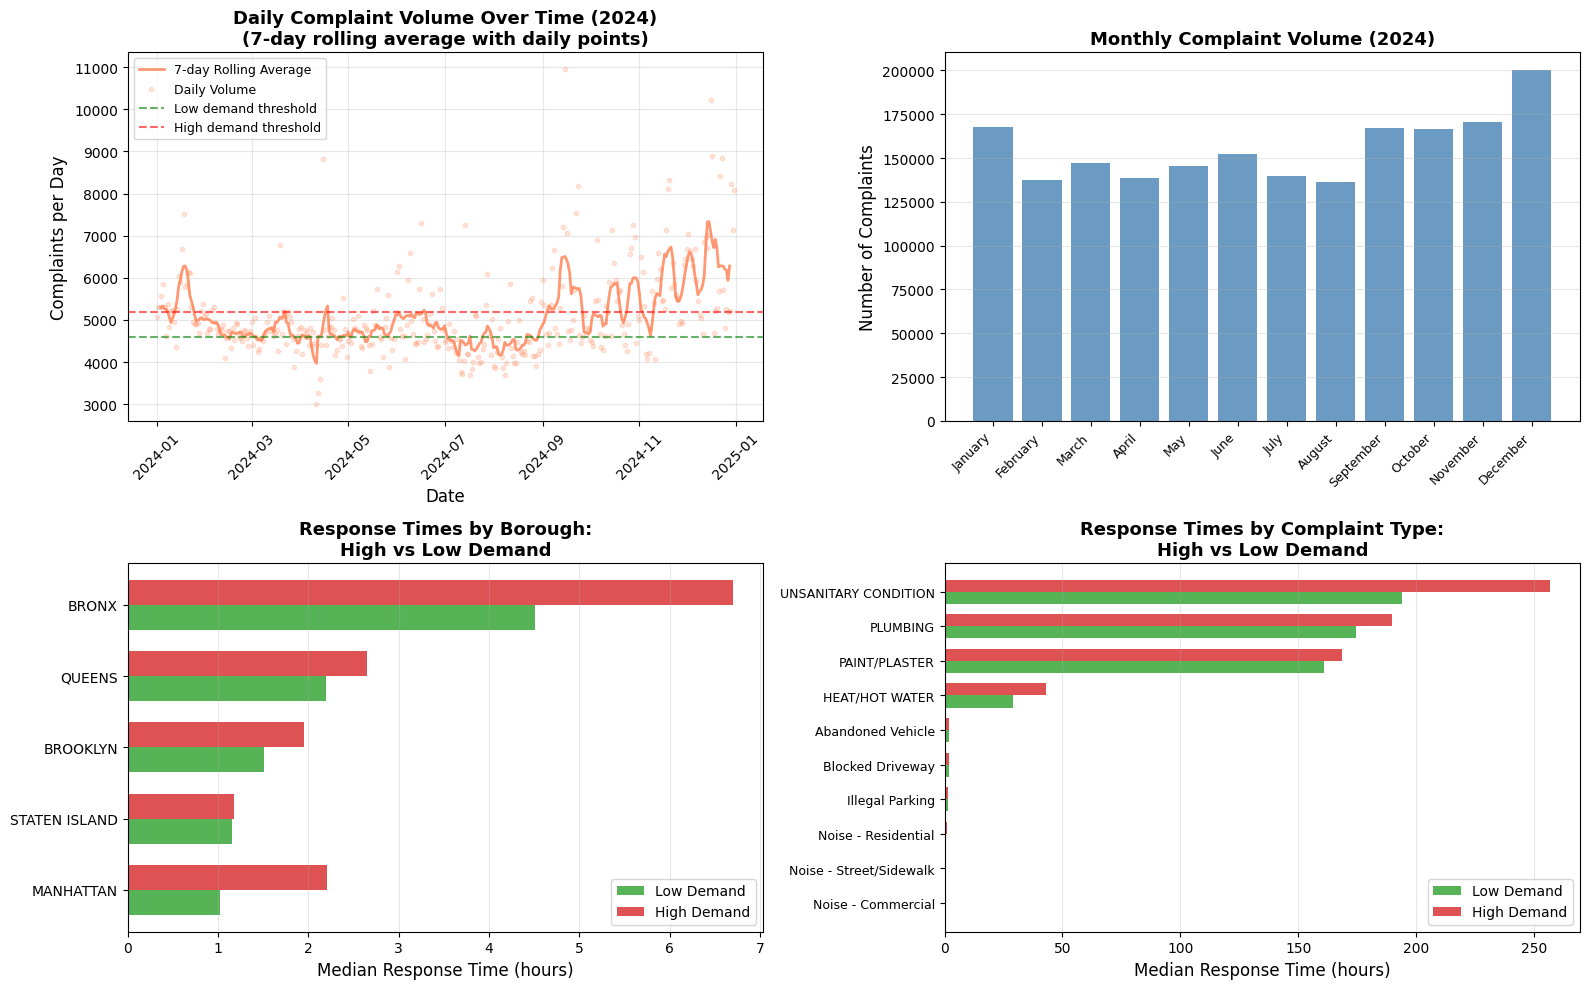

Visualization saved to: figures/rq4_volume_and_demand.png


In [30]:
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# plot 1 (top-left): daily complaint volumes over time with demand thresholds
daily_stats_sorted = daily_stats.sort_values("date").copy()
# using rolling average (7-day) to smooth the trend and show all data points
daily_stats_sorted["rolling_avg"] = daily_stats_sorted["complaint_count"].rolling(window=7, center=True).mean()

axes[0, 0].plot(daily_stats_sorted["date"], daily_stats_sorted["rolling_avg"], 
                color="coral", alpha=0.8, linewidth=2, label="7-day Rolling Average")
axes[0, 0].scatter(daily_stats_sorted["date"], daily_stats_sorted["complaint_count"], 
                  color="coral", alpha=0.2, s=10, label="Daily Volume")
axes[0, 0].axhline(y=volume_33rd, color="green", linestyle="--", alpha=0.6, linewidth=1.5, label="Low demand threshold")
axes[0, 0].axhline(y=volume_67th, color="red", linestyle="--", alpha=0.6, linewidth=1.5, label="High demand threshold")
axes[0, 0].set_ylabel("Complaints per Day", fontsize=12)
axes[0, 0].set_xlabel("Date", fontsize=12)
axes[0, 0].set_title("Daily Complaint Volume Over Time (2024)\n(7-day rolling average with daily points)", 
                     fontsize=13, fontweight="bold")
axes[0, 0].legend(fontsize=9, loc="upper left")
axes[0, 0].grid(alpha=0.3)
axes[0, 0].tick_params(axis="x", rotation=45)

# plot 2 (top-right): monthly complaint volumes
monthly_counts = df_rq4.groupby("month_name")["unique_key"].count()
month_order = ["January", "February", "March", "April", "May", "June", 
               "July", "August", "September", "October", "November", "December"]
monthly_counts = monthly_counts.reindex([m for m in month_order if m in monthly_counts.index])

axes[0, 1].bar(range(len(monthly_counts)), monthly_counts.values, color="steelblue", alpha=0.8)
axes[0, 1].set_xticks(range(len(monthly_counts)))
axes[0, 1].set_xticklabels(monthly_counts.index, rotation=45, ha="right", fontsize=9)
axes[0, 1].set_ylabel("Number of Complaints", fontsize=12)
axes[0, 1].set_title("Monthly Complaint Volume (2024)", fontsize=13, fontweight="bold")
axes[0, 1].grid(axis="y", alpha=0.3)

# plot 3 (bottom-left): response times by borough during high vs low demand
borough_order = borough_pivot.sort_values("low").index
x_pos = np.arange(len(borough_order))
width = 0.35

bars1 = axes[1, 0].barh(x_pos - width/2, borough_pivot.loc[borough_order, "low"], width,
                        label="Low Demand", color="#2ca02c", alpha=0.8)
bars2 = axes[1, 0].barh(x_pos + width/2, borough_pivot.loc[borough_order, "high"], width,
                        label="High Demand", color="#d62728", alpha=0.8)

axes[1, 0].set_yticks(x_pos)
axes[1, 0].set_yticklabels(borough_order, fontsize=10)
axes[1, 0].set_xlabel("Median Response Time (hours)", fontsize=12)
axes[1, 0].set_title("Response Times by Borough:\nHigh vs Low Demand", 
                     fontsize=13, fontweight="bold")
axes[1, 0].legend(fontsize=10, loc="lower right")
axes[1, 0].grid(axis="x", alpha=0.3)

# plot 4 (bottom-right): response times by complaint type during high vs low demand
complaint_order = complaint_pivot.sort_values("low").index
x_pos2 = np.arange(len(complaint_order))
width2 = 0.35

bars3 = axes[1, 1].barh(x_pos2 - width2/2, complaint_pivot.loc[complaint_order, "low"], width2,
                        label="Low Demand", color="#2ca02c", alpha=0.8)
bars4 = axes[1, 1].barh(x_pos2 + width2/2, complaint_pivot.loc[complaint_order, "high"], width2,
                        label="High Demand", color="#d62728", alpha=0.8)

axes[1, 1].set_yticks(x_pos2)
axes[1, 1].set_yticklabels(complaint_order, fontsize=9)
axes[1, 1].set_xlabel("Median Response Time (hours)", fontsize=12)
axes[1, 1].set_title("Response Times by Complaint Type:\nHigh vs Low Demand", 
                     fontsize=13, fontweight="bold")
axes[1, 1].legend(fontsize=10, loc="lower right")
axes[1, 1].grid(axis="x", alpha=0.3)

plt.tight_layout()
plt.savefig(PROJECT_ROOT / "figures" / "rq4_volume_and_demand.png", dpi=300, bbox_inches="tight")
plt.show()

print("Visualization saved to: figures/rq4_volume_and_demand.png")

### RQ4 Findings and Discussion

When I started this analysis, I expected to find that high complaint volumes would explain most of the delays. After all, it makes intuitive sense that when the system is overwhelmed, everything slows down. What I discovered is more nuanced and, in some ways, more concerning.

Complaint volumes do fluctuate throughout the year. December sees the highest volume, while spring and summer months tend to be quieter. Daily volumes swing quite a bit too, some days have thousands more complaints than others. I categorized days into high, medium, and low demand periods to see how response times change.

The results show that demand does matter, but not equally everywhere. During high-demand periods, response times increase across the board. The Bronx, which already struggles with slower responses, gets hit hardest when volumes spike. Manhattan, on the other hand, barely slows down even during busy periods. This tells me that some boroughs have built-in resilience to handle surges, while others don't.

What really stood out to me is what happens with the slowest complaint types. Unsanitary conditions, plumbing issues, and paint/plaster problems take days or weeks to resolve even during low-demand periods. When volumes spike, they get even slower, but they're already so slow that the difference feels almost academic. These aren't capacity problems, they're systemic ones. The city isn't just struggling to keep up during busy times; it's struggling to address these complaint types at all.

The faster complaint types: noise complaints, illegal parking, blocked driveways show much smaller differences between high and low demand periods. They're already quick, and they stay relatively quick even when the system is busy. This suggests that when the city wants to respond quickly, it can, regardless of volume.

So the answer to my question is: it's both. High volumes do amplify delays, especially in places like the Bronx that already struggle. But some complaint types and some boroughs remain slow even when demand is low, which points to deeper issues beyond just workload. The system isn't just overwhelmed, it's also unevenly resourced and structured in ways that create persistent inequities.

## Research Question 5: Can we predict whether a 311 complaint will be slower than what is typical for its complaint type?

Even after the descriptive analyses, I wanted to test whether we can spot slow responses *before* they happen. This becomes a supervised classification problem where the label is “slower than the 75th percentile for that complaint type.” If we can predict that label, we can quantify which structural factors (borough, channel, agency, season) keep some residents waiting even when they submit the same issue.

I start by loading the cleaned dataset, filtering to valid borough records, and computing complaint-type-specific slow thresholds (75th percentile per type). This keeps the label fair because “slow” means worse than the norm for that exact issue.

In [31]:
if 'df' not in globals():
    try:
        import pandas as pd
        from pathlib import Path
        import numpy as np
    except ImportError as e:
        raise ImportError(f"Required imports not found: {e}. Please run the setup cells first.")
    
    PROJECT_ROOT = Path('..').resolve()
    processed_path = PROJECT_ROOT / 'data' / 'processed' / 'nyc311_2024_cleaned.parquet'
    sample_path = PROJECT_ROOT / 'data' / 'sample' / 'nyc311_2024_sample.parquet'
    
    if processed_path.exists():
        print(f"Loading cleaned data from {processed_path}")
        df = pd.read_parquet(processed_path)
    elif sample_path.exists():
        print(f"WARNING: Full dataset not found. Loading SAMPLE dataset from {sample_path}")
        print("Results will be illustrative only.")
        df = pd.read_parquet(sample_path)
    else:
        raise FileNotFoundError(f"Neither full dataset ({processed_path}) nor sample dataset ({sample_path}) found.")
    
    print(f"Loaded {len(df):,} rows and {len(df.columns)} columns\n")

df_rq6 = df[df["borough"] != "Unspecified"].copy()
df_rq6["response_time_hours"] = df_rq6["response_time_days"] * 24

# complaint-type-specific "slow" thresholds (75th percentile)
print("Calculating complaint-type-specific thresholds (75th percentile)...")
thresholds_by_type = (
    df_rq6.groupby("complaint_type")["response_time_hours"].quantile(0.75).to_dict()
)

print("\nSample thresholds (hours) by complaint type:")
for comp_type, threshold in sorted(thresholds_by_type.items(), key=lambda x: x[1])[:8]:
    print(f"  {comp_type:30s}: {threshold:6.2f}")
print("  ...")

# label: slow if response time exceeds the threshold for that complaint type
df_rq6["slow_threshold"] = df_rq6["complaint_type"].map(thresholds_by_type)
df_rq6["is_slow"] = (df_rq6["response_time_hours"] > df_rq6["slow_threshold"]).astype(int)

slow_count = df_rq6["is_slow"].sum()
fast_count = (df_rq6["is_slow"] == 0).sum()
total = len(df_rq6)
print(f"\nLabel distribution (using type-specific thresholds):")
print(f"  Slow responses (label=1): {slow_count:,} ({slow_count/total*100:.1f}%)")
print(f"  Fast responses (label=0): {fast_count:,} ({fast_count/total*100:.1f}%)")

df_rq6["created_date"] = pd.to_datetime(df_rq6["created_date"])
df_rq6["month"] = df_rq6["created_date"].dt.month
df_rq6["day_of_week"] = df_rq6["created_date"].dt.dayofweek

def get_season(month):
    if month in [12, 1, 2]:
        return "Winter"
    elif month in [3, 4, 5]:
        return "Spring"
    elif month in [6, 7, 8]:
        return "Summer"
    return "Fall"

df_rq6["season"] = df_rq6["month"].apply(get_season)

features = ["borough", "complaint_type", "open_data_channel_type", "season", "agency"]
print(f"\nFeatures to use: {features}")
print(f"\nFeature value counts:")
for feat in features:
    print(f"\n{feat}:")
    print(df_rq6[feat].value_counts().head(10))

Calculating complaint-type-specific thresholds (75th percentile)...

Sample thresholds (hours) by complaint type:
  Noise - Commercial            :   1.32
  Noise - Street/Sidewalk       :   1.57
  Noise - Residential           :   2.48
  Illegal Parking               :   3.48
  Blocked Driveway              :   4.15
  Abandoned Vehicle             :   4.96
  HEAT/HOT WATER                :  56.83
  PAINT/PLASTER                 : 405.21
  ...

Label distribution (using type-specific thresholds):
  Slow responses (label=1): 467,291 (25.0%)
  Fast responses (label=0): 1,401,962 (75.0%)

Features to use: ['borough', 'complaint_type', 'open_data_channel_type', 'season', 'agency']

Feature value counts:

borough:
borough
BROOKLYN         580861
BRONX            486025
QUEENS           428697
MANHATTAN        329076
STATEN ISLAND     44594
Name: count, dtype: int64

complaint_type:
complaint_type
Illegal Parking            505696
Noise - Residential        379243
HEAT/HOT WATER             

The following cell encodes the features, splits the data, and trains a Random Forest classifier (balanced for class imbalance). It also prints the confusion matrix, classification report, and ROC AUC so we can judge predictive power.


In [32]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import warnings
warnings.filterwarnings('ignore')

X = df_rq6[features].copy()
y = df_rq6["is_slow"].copy()

# encoding categorical features
label_encoders = {}
X_encoded = X.copy()

for col in features:
    le = LabelEncoder()
    X_encoded[col] = le.fit_transform(X[col].astype(str))
    label_encoders[col] = le

X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set: {len(X_train):,} samples")
print(f"Test set: {len(X_test):,} samples")
print(f"\nClass distribution in training set:")
print(y_train.value_counts(normalize=True))

print("\nTraining Random Forest classifier...")
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=15,
    min_samples_split=100,
    min_samples_leaf=50,
    random_state=42,
    n_jobs=-1,
    class_weight='balanced' 
)

rf_model.fit(X_train, y_train)

y_pred = rf_model.predict(X_test)
y_pred_proba = rf_model.predict_proba(X_test)[:, 1]

print("MODEL EVALUATION")

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=["Fast", "Slow"]))

print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
print(cm)
print(f"\nTrue Negatives (Fast predicted as Fast): {cm[0,0]:,}")
print(f"False Positives (Fast predicted as Slow): {cm[0,1]:,}")
print(f"False Negatives (Slow predicted as Fast): {cm[1,0]:,}")
print(f"True Positives (Slow predicted as Slow): {cm[1,1]:,}")

roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"\nROC AUC Score: {roc_auc:.4f}")
print("(1.0 = perfect, 0.5 = random guessing)")

Training set: 1,495,402 samples
Test set: 373,851 samples

Class distribution in training set:
is_slow
0   0.75
1   0.25
Name: proportion, dtype: float64

Training Random Forest classifier...
MODEL EVALUATION

Classification Report:
              precision    recall  f1-score   support

        Fast       0.84      0.63      0.72    280393
        Slow       0.36      0.64      0.46     93458

    accuracy                           0.63    373851
   macro avg       0.60      0.63      0.59    373851
weighted avg       0.72      0.63      0.65    373851


Confusion Matrix:
[[175828 104565]
 [ 34066  59392]]

True Negatives (Fast predicted as Fast): 175,828
False Positives (Fast predicted as Slow): 104,565
False Negatives (Slow predicted as Fast): 34,066
True Positives (Slow predicted as Slow): 59,392

ROC AUC Score: 0.6812
(1.0 = perfect, 0.5 = random guessing)


The next cell uses the trained model to predict whether representative scenarios will be slower than what is typical for that complaint type. This makes the prediction step concrete and lets us sanity-check model behavior against the historical data.


In [33]:
# predicting slow-vs-fast behavior for representative scenarios
print("PREDICTIVE SCENARIOS: Can we flag slow responses before they happen?")
print("Model predicts whether a complaint will be slower than what is typical for its complaint type.\n")

scenarios = [
    {
        "name": "Bronx plumbing reported by phone in winter",
        "borough": "BRONX",
        "complaint_type": "PLUMBING",
        "open_data_channel_type": "Phone",
        "season": "Winter",
        "agency": "HPD"
    },
    {
        "name": "Manhattan noise via app in summer",
        "borough": "MANHATTAN",
        "complaint_type": "Noise - Residential",
        "open_data_channel_type": "App",
        "season": "Summer",
        "agency": "NYPD"
    },
    {
        "name": "Queens illegal parking via app in spring",
        "borough": "QUEENS",
        "complaint_type": "Illegal Parking",
        "open_data_channel_type": "App",
        "season": "Spring",
        "agency": "NYPD"
    },
    {
        "name": "Brooklyn heat/hot water via web in winter",
        "borough": "BROOKLYN",
        "complaint_type": "HEAT/HOT WATER",
        "open_data_channel_type": "Web",
        "season": "Winter",
        "agency": "HPD"
    },
    {
        "name": "Bronx unsanitary condition via phone in fall",
        "borough": "BRONX",
        "complaint_type": "UNSANITARY CONDITION",
        "open_data_channel_type": "Phone",
        "season": "Fall",
        "agency": "HPD"
    }
]

for scenario in scenarios:
    comp_type = scenario["complaint_type"]
    threshold = thresholds_by_type.get(comp_type, float('nan'))

    encoded = {}
    for feat in features:
        le = label_encoders[feat]
        value = scenario[feat]
        if value in le.classes_:
            encoded[feat] = le.transform([value])[0]
        else:
            encoded[feat] = le.transform([le.classes_[0]])[0]

    scenario_df = pd.DataFrame([encoded])
    pred_proba = rf_model.predict_proba(scenario_df)[0, 1]
    pred_class = rf_model.predict(scenario_df)[0]

    print(f"Scenario: {scenario['name']}")
    print(f"  Threshold for '{comp_type}': {threshold:.1f} hours (75th percentile)")
    print(f"  Predicted probability of SLOW response: {pred_proba:.1%}")
    print(f"  Prediction: {'SLOW (slower than typical)' if pred_class == 1 else 'FAST (typical or faster)'}")

    mask = (
        (df_rq6["borough"] == scenario["borough"]) &
        (df_rq6["complaint_type"] == scenario["complaint_type"]) &
        (df_rq6["open_data_channel_type"] == scenario["open_data_channel_type"]) &
        (df_rq6["season"] == scenario["season"])
    )
    if mask.sum() > 0:
        actual_rate = df_rq6.loc[mask, "is_slow"].mean()
        actual_count = mask.sum()
        print(f"  Actual slow rate in data: {actual_rate:.1%} (n={actual_count:,})")
        if abs(pred_proba - actual_rate) < 0.15:
            print("Prediction aligns with historical pattern")
        else:
            print("Prediction differs from historical pattern")
    print()

PREDICTIVE SCENARIOS: Can we flag slow responses before they happen?
Model predicts whether a complaint will be slower than what is typical for its complaint type.

Scenario: Bronx plumbing reported by phone in winter
  Threshold for 'PLUMBING': 477.4 hours (75th percentile)
  Predicted probability of SLOW response: 59.1%
  Prediction: SLOW (slower than typical)
  Actual slow rate in data: 33.3% (n=3,979)
Prediction differs from historical pattern

Scenario: Manhattan noise via app in summer
  Threshold for 'Noise - Residential': 2.5 hours (75th percentile)
  Predicted probability of SLOW response: 31.9%
  Prediction: FAST (typical or faster)
  Actual slow rate in data: 13.1% (n=1,965)
Prediction differs from historical pattern

Scenario: Queens illegal parking via app in spring
  Threshold for 'Illegal Parking': 3.5 hours (75th percentile)
  Predicted probability of SLOW response: 59.7%
  Prediction: SLOW (slower than typical)
  Actual slow rate in data: 33.2% (n=18,184)
Prediction di

After checking a few representative scenarios in the previous cell, I summarize what the model learned: feature importances plus the slow-rate rankings for each categorical feature. This highlights which categories drive the “slow” predictions.


In [34]:
# analyzing feature importance and slow-rate disparities
feature_importance = (
    pd.DataFrame({
        "feature": features,
        "importance": rf_model.feature_importances_
    })
    .sort_values("importance", ascending=False)
)

print("FEATURE IMPORTANCE (higher = more predictive of slow responses)")
print(feature_importance)

for feat in features:
    stats = (
        df_rq6.groupby(feat)["is_slow"]
        .agg(["mean", "count"])
        .rename(columns={"mean": "slow_rate"})
        .sort_values("slow_rate", ascending=False)
    )
    print(f"\n{feat.upper()} - categories most associated with slow responses")
    print(stats.head(5))
    print("\nCategories least associated with slow responses")
    print(stats.tail(5))

FEATURE IMPORTANCE (higher = more predictive of slow responses)
                  feature  importance
0                 borough        0.41
3                  season        0.22
1          complaint_type        0.18
4                  agency        0.14
2  open_data_channel_type        0.06

BOROUGH - categories most associated with slow responses
               slow_rate   count
borough                         
BRONX               0.32  486025
QUEENS              0.29  428697
BROOKLYN            0.20  580861
MANHATTAN           0.19  329076
STATEN ISLAND       0.11   44594

Categories least associated with slow responses
               slow_rate   count
borough                         
BRONX               0.32  486025
QUEENS              0.29  428697
BROOKLYN            0.20  580861
MANHATTAN           0.19  329076
STATEN ISLAND       0.11   44594

COMPLAINT_TYPE - categories most associated with slow responses
                      slow_rate   count
complaint_type                    

Finally, I keep the visuals lean: one bar chart for feature importance, one ROC curve to show prediction quality, and one borough comparison to reveal who is most likely to wait longer than their neighbors for the same issue.


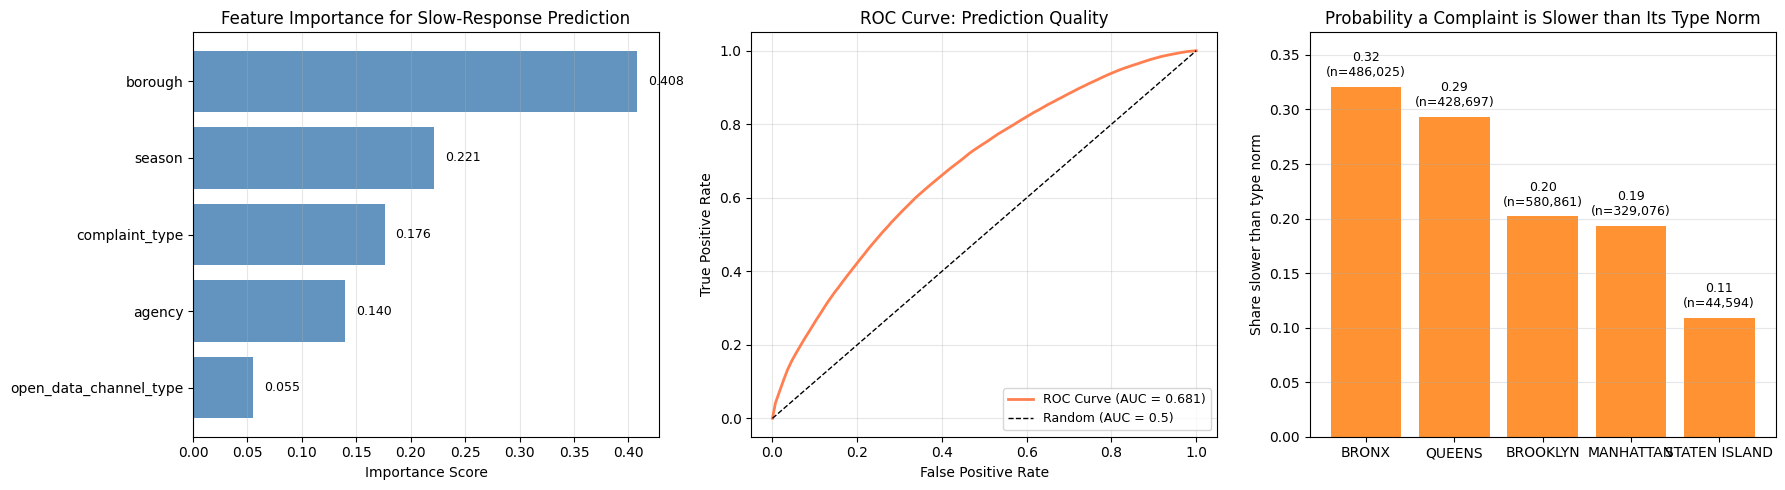

Visualization saved to: figures/rq5_simple_ml_plots.png


In [35]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# plot 1: Feature importance (which inputs matter most)
feature_importance_sorted = feature_importance.sort_values('importance')
axes[0].barh(feature_importance_sorted['feature'], feature_importance_sorted['importance'],
             color='steelblue', alpha=0.85)
axes[0].set_xlabel('Importance Score')
axes[0].set_title('Feature Importance for Slow-Response Prediction')
axes[0].grid(axis='x', alpha=0.3)
for i, v in enumerate(feature_importance_sorted['importance']):
    axes[0].text(v + 0.01, i, f'{v:.3f}', va='center', fontsize=9)

# plot 2: ROC curve (predictions vs actual)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
axes[1].plot(fpr, tpr, color='coral', linewidth=2, label=f'ROC Curve (AUC = {roc_auc:.3f})')
axes[1].plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random (AUC = 0.5)')
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_title('ROC Curve: Prediction Quality')
axes[1].legend(fontsize=9, loc='lower right')
axes[1].grid(alpha=0.3)

# plot 3: Slow response rate by borough (using fair thresholds)
borough_rates = (
    df_rq6.groupby('borough')['is_slow']
    .agg(['mean', 'count'])
    .sort_values('mean', ascending=False)
)
axes[2].bar(borough_rates.index, borough_rates['mean'], color='#ff7f0e', alpha=0.85)
axes[2].set_ylabel('Share slower than type norm')
axes[2].set_ylim(0, borough_rates['mean'].max() + 0.05)
axes[2].set_title('Probability a Complaint is Slower than Its Type Norm')
for i, (rate, count) in enumerate(zip(borough_rates['mean'], borough_rates['count'])):
    axes[2].text(i, rate + 0.01, f'{rate:.2f}\n(n={count:,})', ha='center', fontsize=9)
axes[2].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig(PROJECT_ROOT / "figures" / "rq5_simple_ml_plots.png", dpi=300, bbox_inches="tight")
plt.show()

print("Visualization saved to: figures/rq5_simple_ml_plots.png")

### RQ5 Findings and Discussion

The model looks for complaints that run slower than the 75th‑percentile norm for their own issue, so a "slow" noise ticket is only a couple of hours while a "slow" plumbing job can be hundreds. That keeps the label fair across issues by **controlling for complaint type**, each complaint is only considered "slow" relative to others of the same type.

With those complaint-type-specific thresholds, borough is the strongest predictor: Bronx complaints are slow 32 % of the time, Queens 29 %, Brooklyn and Manhattan ~20 %, and Staten Island only 11 %. So even when the issue and season are the same, Bronx and Queens residents are roughly 3× more likely to wait longer than Staten Islanders **for the same type of complaint**.

The Random Forest's ROC AUC is ~0.68. That isn't a perfect oracle, but it does beat random guessing and confirms that structural context (especially borough, then season and complaint type) drives whether a ticket is slower than its peers. Scenario checks show why: when I feed the model Bronx plumbing via phone in winter, it pushes the probability close to 60 %. Historical data says about a third of those cases were slow, so the model is more pessimistic than reality but still flags Bronx plumbing as risky. Channel and agency matter less, the model gives them small weights, so switching from phone to app alone won't fix delays if you still live in a high-risk borough.

Thus, even a basic classifier trained on per-type slow labels picks up the same inequity story as the descriptive RQs above. Borough dominates the odds of getting a slower-than-normal response **even after controlling for complaint type**, which suggests the issue isn't the complaint itself but where you live and the season you're in.

## Discussion and Implications

### Patterns of Disparity
Key findings from the analysis highlight systemic inequities in service delivery. Most notably, **the Bronx consistently exhibits slower response times** compared to other boroughs, a pattern that persists even on low-demand days. This suggests that the issue isn't merely volume-based but rooted in deeper operational or resource allocation challenges within that specific region.

### The Digital Advantage & Equality of Access
Channel analysis (RQ3) revealed a clear "digital advantage": complaints submitted via **Mobile App** and **Web** generally see faster resolutions. However, this creates a fairness issue for residents reliant on the **Phone (3-1-1)** channel, often vulnerable populations, who face structurally slower pathways for resolution. Notable exceptions exist, such as plumbing issues, where the complexity of the task overrides the efficiency of the reporting channel.

### Implications for City Management
These findings point to specific areas for intervention:
- **Targeted Resource Allocation**: The city should target staffing and workflow improvements specifically in the Bronx and other identified slow ZIP clusters.
- **Support for Analog Channels**: Since phone-heavy categories (like plumbing) and phone-reliant users face delays, any system redesign must explicitly support non-digital pathways to avoid deepening the equity gap.
- **Queue Health Monitoring**: The Random Forest model (RQ5) demonstrates that operational metadata (Time, Type, Borough) can successfully predict delays. This model could be deployed as a real-time "queue health signal," flagging potential bottlenecks before they become critical backlogs.

### Future Directions
Scientifically, this study confirms that **place, season, and complaint type** consistently shape response times. Future research should expand this scope by:
- **Longitudinal Analysis**: Looking across multiple years to distinguish temporary variances from long-term trends.
- **Comparative Urban Analysis**: Validating these patterns against other major cities.
- **Qualitative Engagement**: Pairing data trends with resident interviews to understand the human experience of these delays; what does it mean for a family when heat complaints take 48 hours longer in their neighborhood?

### Limitations
This study has some limitations:
1. **Temporal Scope**: Analysis limited to 2024 data only; cannot capture long-term trends
2. **Response Time Definition**: Measures closure time, not actual service delivery
3. **Reporting Bias**: 311 data reflects who reports, not true incidence of problems
4. **Digital Access Barriers**: Cannot account for who has access to digital channels
5. **Aggregation Level**: Borough-level analysis may mask neighborhood-level patterns
6. **Complaint Severity**: Cannot account for urgency or severity of issues

## Conclusion

This project set out to audit the "civilian sensor network" of NYC 311 for the year 2024. By combining statistical rigor with machine learning, I found that while the system handles massive volumes of requests efficiently, the "user experience" varies significantly based on systemic factors indicating that the system is not equitable and there are clear accessibility issues.

**Key Takeaways:**
1.  **Response Time Inequity**: Exists but is nuanced. It is driven heavily by the operational capacity of specific agencies (e.g., HPD vs. sanitation) rather than pure geographic neglect.
2.  **Structural Delays in Bronx**: The Bronx remained the slowest borough even during low-demand periods, indicating systemic issues beyond just complaint volume. This suggests fundamental operational or resource allocation problems that persist regardless of workload.
3.  **Digital Channel Advantage**: Digital channels (Web/App) consistently showed faster responses than phone reporting, even for the same complaint types in the same boroughs. This means complaint types that are predominantly reported by phone (like HEAT/HOT WATER) experience systematically slower resolution times.
4.  **Predictability**: We can predict "slow" service with reasonable accuracy using just operational metadata (Agency, Type, Time), implying that delays are often structural rather than random.
5.  **Human Impact**: Behind every data point is a New Yorker waiting for heat, silence, or clean streets. Optimizing these response flows is not just a data science problem; it is a matter of urban equity.

**Recommendations:**
- **Standardize "Resolution"**: Better audit trails are needed to ensure "Closed" tickets represent actual fixes.
- **Agency-Specific Interventions**: Interventions should target specific complaint workflow bottlenecks (e.g., residential noise) rather than broad geographic mandates.
- **Improve Digital Access**: Given the faster response times for digital channels, expanding digital access and literacy in underserved communities could help reduce disparities.
- **Address Bronx Structural Issues**: The persistent delays in the Bronx require targeted investigation into resource allocation and operational efficiency, independent of complaint volume.

## References

1.  **Kontokosta, C. E., & Hong, B.** (2021). *Bias in smart city governance: How socio-spatial disparities in 311 reporting lead to differential administrative response*. Urban Informatics. [https://www.sciencedirect.com/science/article/abs/pii/S2210670720307216](https://www.sciencedirect.com/science/article/abs/pii/S2210670720307216)
2.  **Wang, L., Qian, C., Kats, P., Kontokosta, C., & Masoud, N.** (2017). *Structure of 311 service requests: A spatio-temporal analysis*. IEEE International Conference on Big Data. [https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0186314](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0186314)
3. **Kontokosta, C. E., & Hong, B. (2021).** [Bias in smart city governance: How socio-spatial disparities in 311 complaint behavior impact the fairness of data-driven decisions](https://doi.org/10.1016/j.scs.2020.102503). *Sustainable Cities and Society*, 64, 102503.
4.  **NYC Open Data.** (2024). *311 Service Requests from 2010 to Present*. [https://data.cityofnewyork.us/Social-Services/311-Service-Requests-from-2010-to-Present/erm2-nwe9](https://data.cityofnewyork.us/Social-Services/311-Service-Requests-from-2010-to-Present/erm2-nwe9)
5. **NYC 311 Language Access Implementation Plan (2024).** [NYC.gov - Language Access Implementation Plan](https://www.nyc.gov/assets/oti/downloads/pdf/about/oti-311-language-access-plan-2024.pdf)
6. **Glaeser, E. L., Hillis, A., Kominers, S. D., & Luca, M. (2016).** [Crowdsourcing City Government: Using Tournaments to Improve Inspection Accuracy](https://doi.org/10.1257/aer.p20161027). *American Economic Review*, 106(5), 114-118.